In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import pandas as pd
from pupil_src.shared_modules import file_methods
import pprint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import csv
import json
import seaborn as sns
from scipy import stats
from scipy.ndimage.filters import gaussian_filter

mpl.rcParams['figure.dpi'] = 144
mpl.rcParams['figure.figsize'] = (10, 7)

In [2]:
def load_json(file):
    data = None
    with open(file) as f:
        data = json.load(f)
    return data

In [92]:
all_trials_df = pd.read_pickle('frames/all_trials_df.pickle')
block_df = pd.read_pickle('frames/block_df.pickle')
tower_df = pd.read_pickle('frames/tower_df.pickle')
TOWERS = load_json('../TrialData/towers.json').get('towers')

### Predicting fall direction

[0.5393609675624127, 0.5848773199164443]


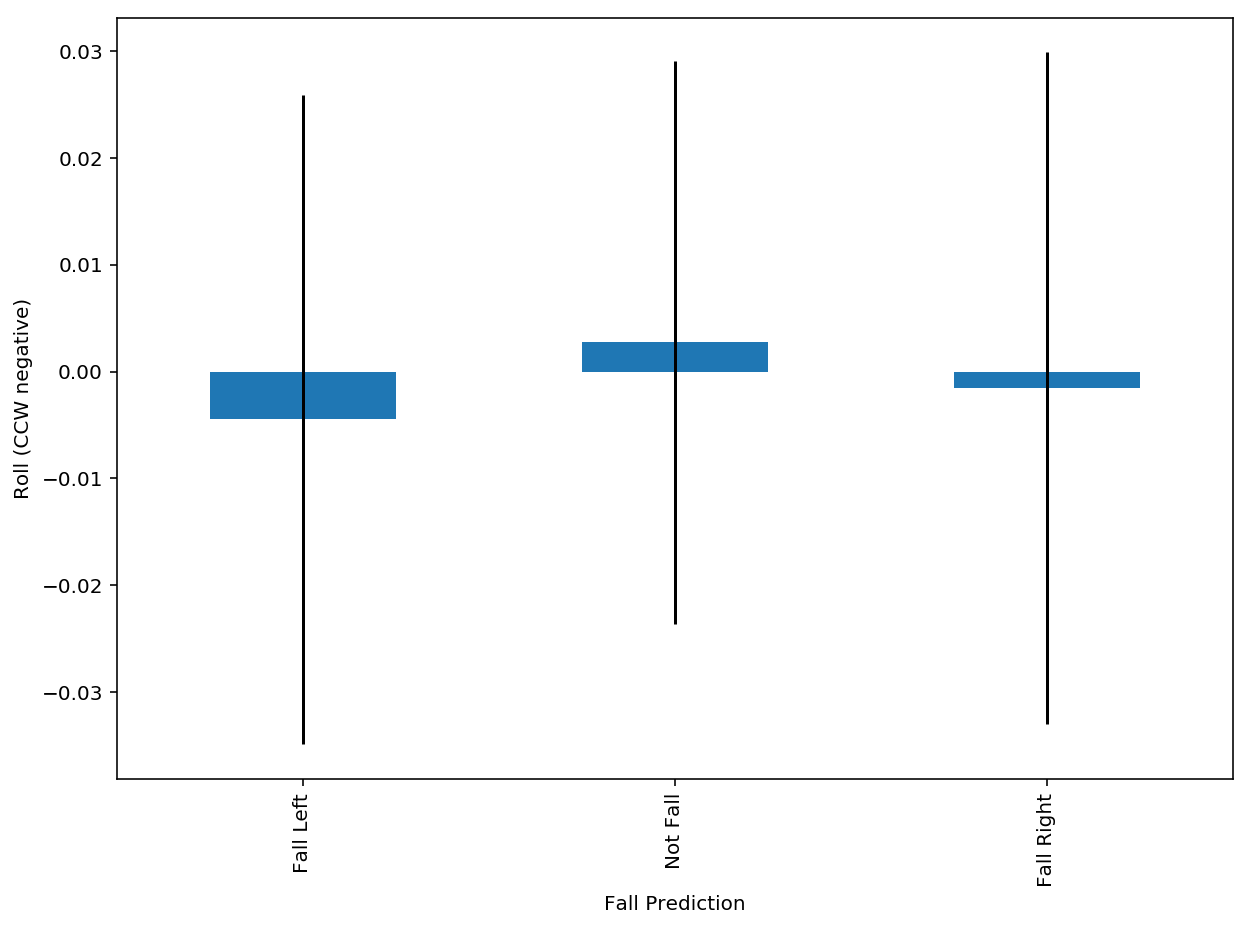

In [225]:
from scipy.stats import f_oneway
ax = plt.gca()
errors = all_trials_df.groupby('response_int')['mean_roll_norm'].std()
all_trials_df.groupby('response_int')['mean_roll_norm'].mean().plot.bar(ax=ax, yerr=errors)
# TODO: Add error bars

left_val = all_trials_df[all_trials_df.response_int == -1].mean_roll_norm
right_val = all_trials_df[all_trials_df.response_int == 1].mean_roll_norm
nofall_val = all_trials_df[all_trials_df.response_int == 0].mean_roll_norm

stat, pval = f_oneway(
    left_val[~left_val.isnull()],
    right_val[~right_val.isnull()],
    nofall_val[~nofall_val.isnull()]  
)
print([stat, pval])

ax.set_xlabel("Fall Prediction")
ax.set_xticklabels(['Fall Left', 'Not Fall', 'Fall Right'])
ax.set_ylabel("Roll (CCW negative)")
plt.savefig('figures/roll.png')
plt.show()

In [222]:
all_trials_df[all_trials_df.response_int == -1].mean_roll_norm.values

array([-0.05021731,         nan,  0.00240304,  0.02563889,  0.02169268,
        0.03464726,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -0.04942472,
       -0.02687463,  0.03283584, -0.01838316, -0.04032951,  0.03954076,
        0.00600264,  0.00759373, -0.01387031, -0.04550913,  0.00894827,
       -0.02879765, -0.0435377 ,  0.01159446, -0.01731478, -0.00710449,
       -0.01578012,  0.06665937,  0.00569613,  0.01215661, -0.02735088,
       -0.00507572, -0.0048578 , -0.00117082,  0.02477243,  0.01868855,
        0.00346464,  0.02981418,  0.00795774, -0.02563402, -0.02136523,
       -0.08335404])

In [61]:
for id, row in all_trials_df.iterrows():
    all_trials_df.loc[id, 'most_com_unstable_block'] = tower_df.loc[row.tower].most_com_unstable_block
    all_trials_df.loc[id, 'most_local_unstable_block'] = tower_df.loc[row.tower].most_local_unstable_block    

0.23896126705902562


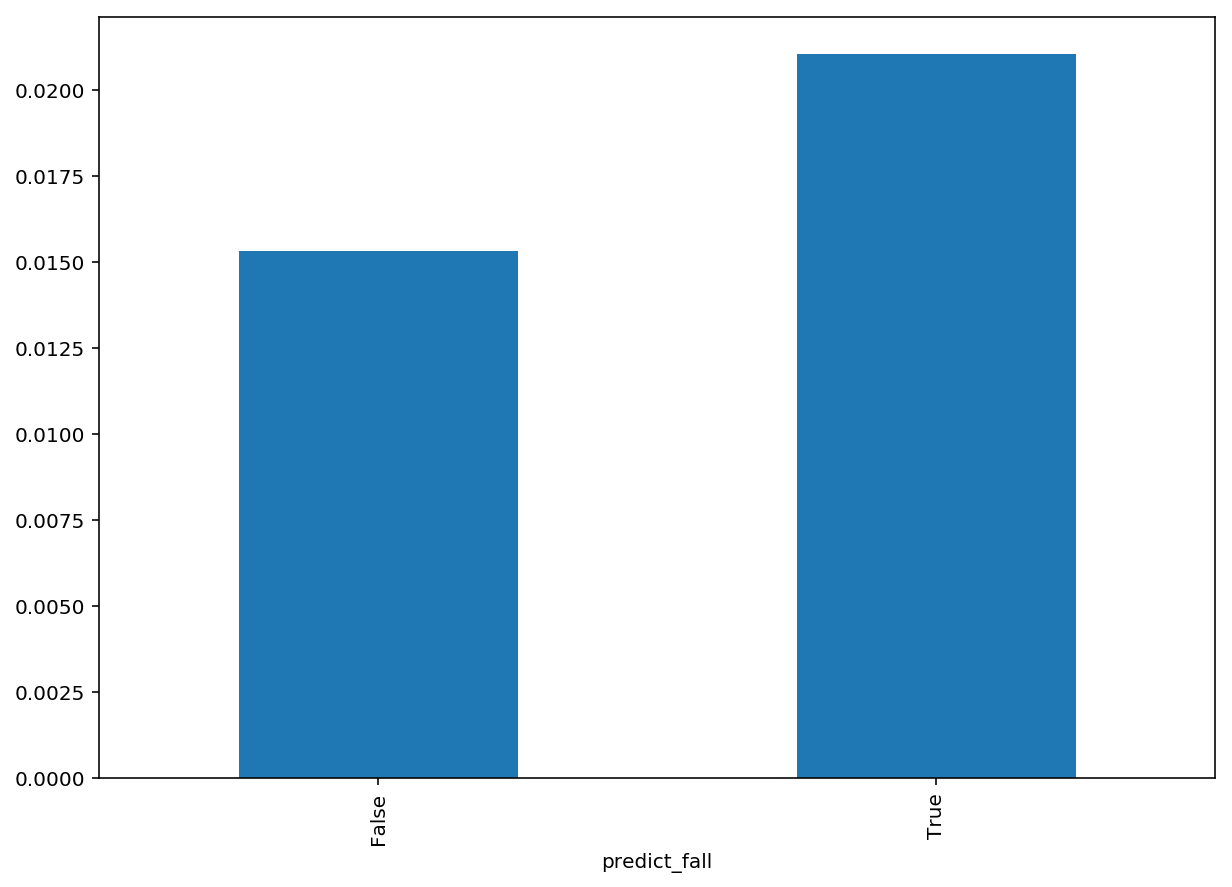

In [62]:
all_trials_df.groupby('predict_fall').roll_std.mean().plot.bar()

l1 = all_trials_df[all_trials_df.predict_fall == True].roll_std
l2 = all_trials_df[all_trials_df.predict_fall == False].roll_std
tstat, pval = stats.ttest_ind(l1[~l1.isnull()].values, l2[~l2.isnull()].values)
print(pval)

0.7962252141550485


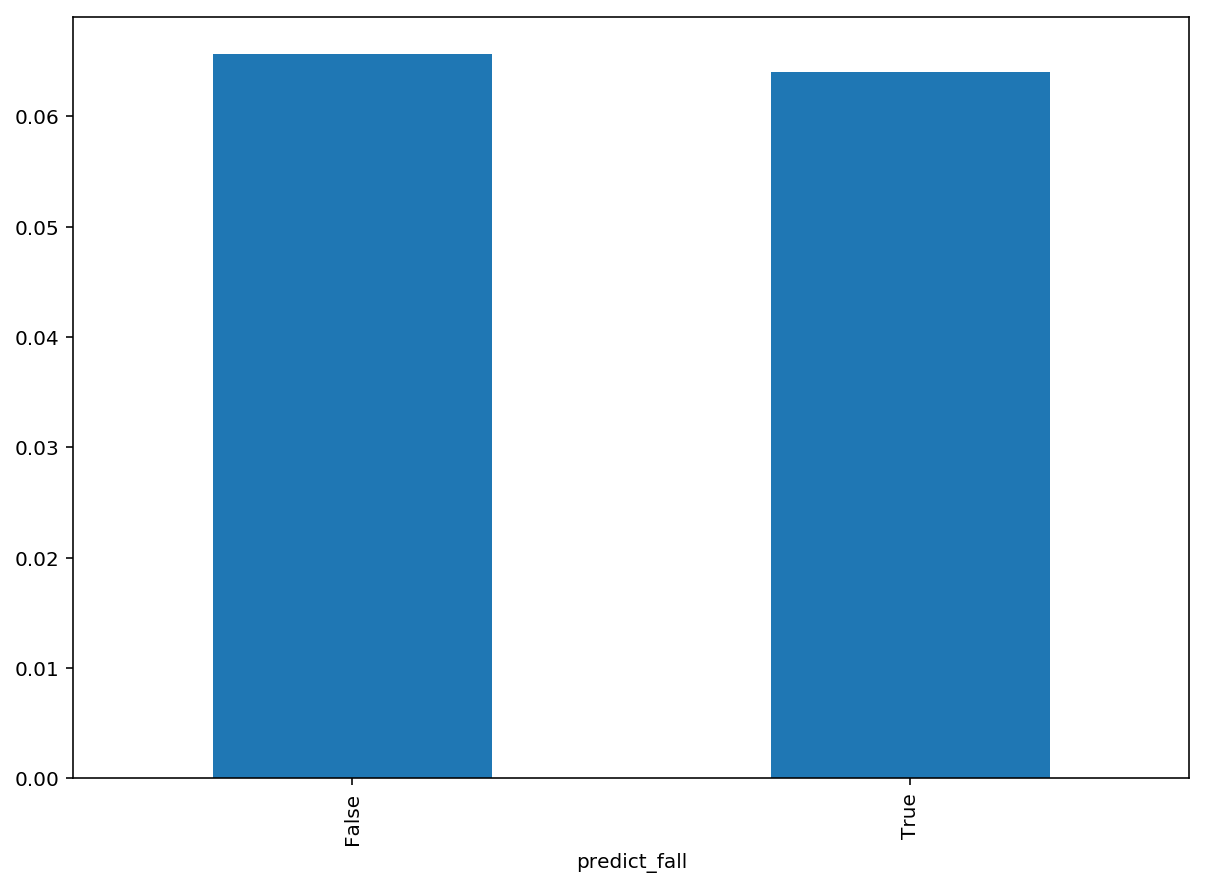

In [63]:
all_trials_df.groupby('predict_fall').pitch_std.mean().plot.bar()

l1 = all_trials_df[all_trials_df.predict_fall == True].pitch_std
l2 = all_trials_df[all_trials_df.predict_fall == False].pitch_std
tstat, pval = stats.ttest_ind(l1[~l1.isnull()].values, l2[~l2.isnull()].values)
print(pval)

0.1175737963025565


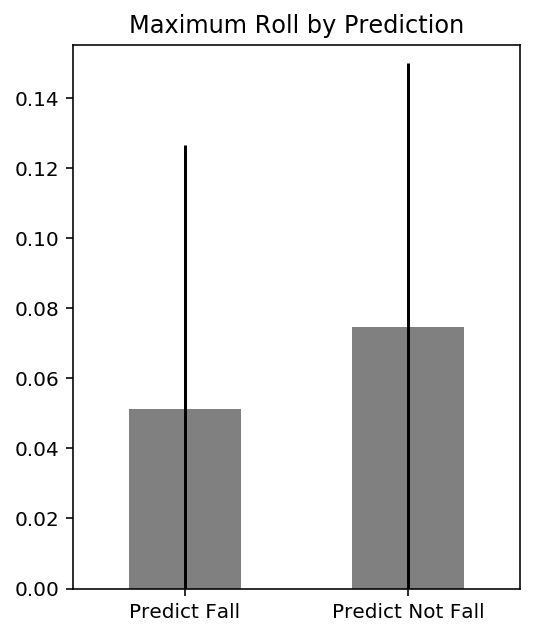

In [275]:
fig, ax = plt.subplots(figsize=(4, 5))

errors = all_trials_df[all_trials_df.predict_fall == True].max_abs_roll.std()
all_trials_df.groupby('predict_fall').max_abs_roll.mean().plot.bar(yerr=errors, color='gray', ax=ax, rot=0)

l1 = all_trials_df[all_trials_df.predict_fall == True].max_abs_roll
l2 = all_trials_df[all_trials_df.predict_fall == False].max_abs_roll
tstat, pval = stats.ttest_ind(l1[~l1.isnull()].values, l2[~l2.isnull()].values)
ax.set_title("Maximum Roll by Prediction")
ax.set_xticklabels(['Predict Fall', 'Predict Not Fall'])
ax.set_ylim((0, 0.155))
ax.set_xlabel('')
plt.savefig('figures/max_roll_by_response.png')

print(pval)

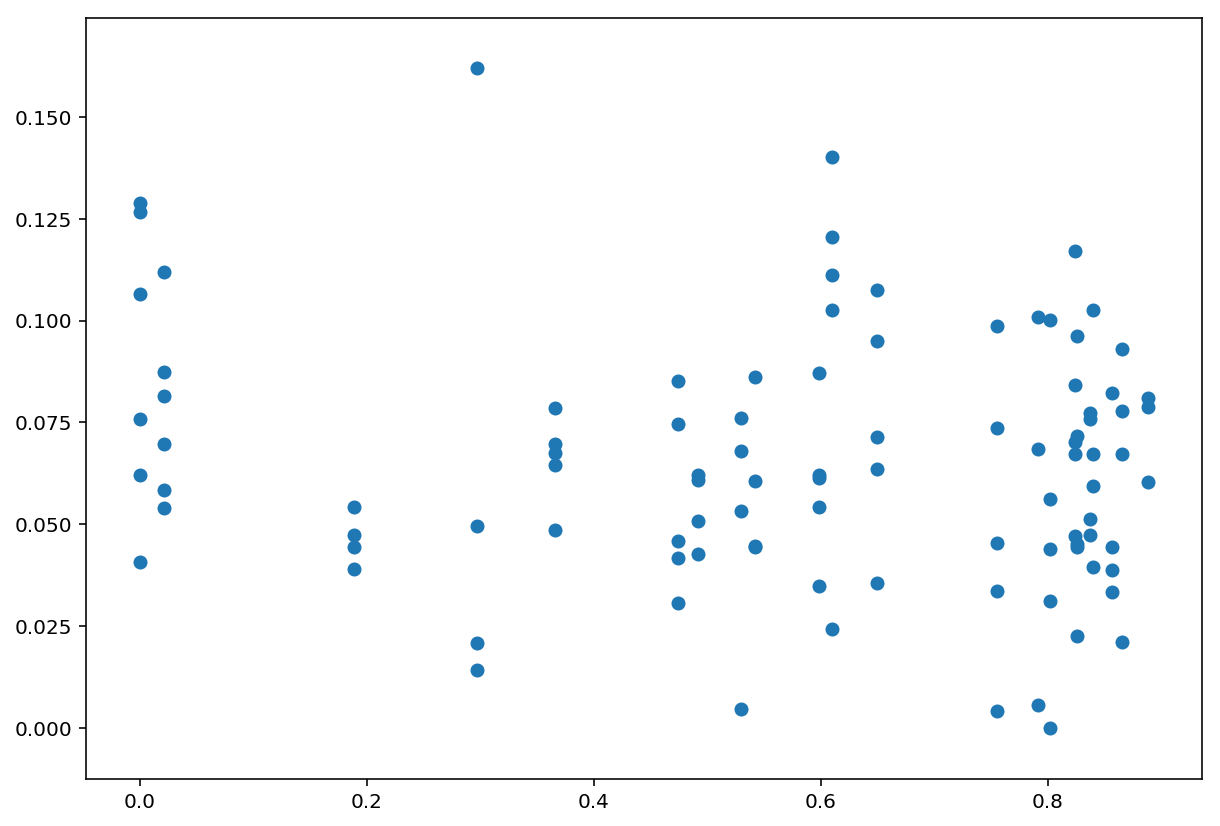

In [68]:
plt.scatter(all_trials_df.most_com_unstable_block, all_trials_df.pitch_std)

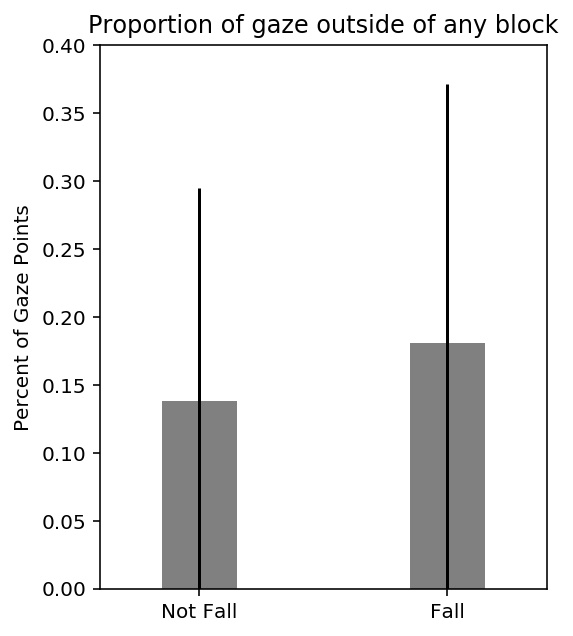

[1.2488910494323653, 0.21417686881385228]


In [274]:
fig, ax = plt.subplots(figsize=(4, 5))
errors = all_trials_df.groupby('predict_fall')['pct_backstop'].std()
all_trials_df.groupby('predict_fall')['pct_backstop'].mean().plot.bar(ax=ax, width=0.3, color="gray", yerr=errors, rot=0)

ax.set_title("Proportion of gaze outside of any block")
ax.set_xlabel("")
ax.set_ylim((0, 0.4))
ax.set_xticklabels(['Not Fall', 'Fall'])
ax.set_ylabel("Percent of Gaze Points")
plt.savefig('figures/gaze_backstop.png')
plt.show()

pf = all_trials_df[all_trials_df.predict_fall == True].pct_backstop
pnf = all_trials_df[all_trials_df.predict_fall == False].pct_backstop
tstat, pval = stats.ttest_ind(pf.values, pnf.values)
print([tstat, pval])

In [17]:
def plot_tower(tower_index, ax=None, c='r', block_stabilities=None):
    y_cursor = 0
    if ax is None:
        ax = plt
    for i, block in enumerate(TOWERS[tower_index].get('blocks')):
        x_offset = block.get('x')
        w = block.get('w')
        h = block.get('h')
        tl = (-w/2 + x_offset, y_cursor + h)
        br = (w/2 + x_offset, y_cursor)
        if block_stabilities:
            c = cm.inferno(block_stabilities[i])
        draw_rect(ax, tl, br, c=c)
        y_cursor += h
    

def plot_tower_and_all_gazepoints(df, tower_id=0, ppid=None, heatmap=False, bins=50, with_roi=False, ax=None):
    '''
    Set ppid=None for all gazepoints across subjects
    '''
    XW = [-10, 10]
    YW = [0, 30]
    if ax is None:
        ax = plt.gca()
    
    plot_tower(tower_id, ax, c='white' if heatmap else 'r')
    
    gazepoints = []
    if ppid is None:
        gaze_df = df[df.tower == tower_id]
    else:
        gaze_df = df[(df.ppid == ppid) & (df.tower == tower_id)]        
    for tid, row in gaze_df.iterrows():
        gazepoints.extend(row.gazepoints)
    
    # Scatter hits
    X, Y, C, MARKS, SIZES = [], [], [], [], []
    for gp in gazepoints:
        hit_key = gp.get('hit_key')
        post_response = gp.get('post_response')
        block = 'block' in hit_key
        if block:
            color_id = int(hit_key.replace('block', ''))
        else:
            color_id = 11
        x = gp.get('x')
        y = gp.get('y')
        if not post_response:
            X.append(x)
            Y.append(y)
            C.append(color_id)
            SIZES.append(0.2 if post_response else 1)
    if heatmap:
#         h, xedges, yedges, img = ax.hist2d(X, Y, bins=bins, cmap='plasma') 
        heatmap, xedges, yedges = np.histogram2d(X, Y, bins=100, range=[XW, YW])
        blurred_heatmap = gaussian_filter(heatmap, sigma=2)
#         extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        extent = [XW[0], XW[1], YW[0], YW[1]]
        ax.imshow(blurred_heatmap.T, extent=extent, origin='lower', interpolation='nearest')        
        if with_roi:
            roi_s = tower_df.loc[tower_id].roi_s
            roi_e = tower_df.loc[tower_id].roi_e
            rect_w = xedges[-1] - xedges[0]
            rect = patches.Rectangle((xedges[0], roi_s),rect_w,roi_e - roi_s,linewidth=0,facecolor='gray', alpha=0.5)
            ax.add_patch(rect)
    else:
        ax.scatter(X, Y, c=C, s=SIZES)
    ax.set_xlim(XW)
    ax.set_ylim(YW) 
    

def plot_hmd_rotation(row):
    roll_list = []
    yaw_list = []
    pitch_list = []
    for gp in row.gazepoints:
        roll = gp.get('roll')
        yaw = gp.get('yaw')
        pitch = gp.get('pitch')        
        roll_list.append(roll)
        yaw_list.append(yaw)
        pitch_list.append(pitch)     
    xaxis = range(len(roll_list))
    fig, axs = plt.subplots(1, 3)
    for ax, data, label in zip(axs, [roll_list, yaw_list, pitch_list], ["Roll", "Yaw", "Pitch"]):
        ax.plot(xaxis, data, label=label)
        ax.set_title(label)
    plt.show()
    
def plot_trial_timeseries(row):
    '''
    Plot xaxis, yaxis and HMD rotation vs time centered at selection
    '''
    roll_list = []
    X = []
    Y = []
    TIME = []
    ts_response = row.ts_response
    for gp in row.gazepoints:
        roll = gp.get('roll')
        yaw = gp.get('yaw')
        pitch = gp.get('pitch')        
        roll_list.append(roll)
        X.append(gp.get('x'))
        Y.append(gp.get('y'))
        ts = gp.get('ts')
        time_rel = ts - ts_response
        TIME.append(time_rel)
    xaxis = TIME
    fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.5})
    for ax, data, label in zip(axs, [X, Y, roll_list], ["X", "Y", "Roll"]):
        ax.scatter(xaxis, data, label=label, s=1)
        ax.set_xlabel("Time (secs, relative to response)")
        ax.plot([0, 0], [min(data), max(data)], c='black')
        ax.set_title(label)
    plt.suptitle("Gaze and head tilt before and after response (black line)")
    plt.show()    

    
def draw_rect(ax, tl, br, c='r', lw=1):
    X = [tl[0], br[0], br[0], tl[0], tl[0]]
    Y = [tl[1], tl[1], br[1], br[1], tl[1]]
    ax.plot(X, Y, c=c, linewidth=lw)

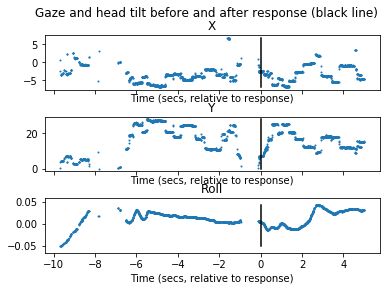

In [18]:
plot_trial_timeseries(all_trials_df.loc['05_trial_3'])

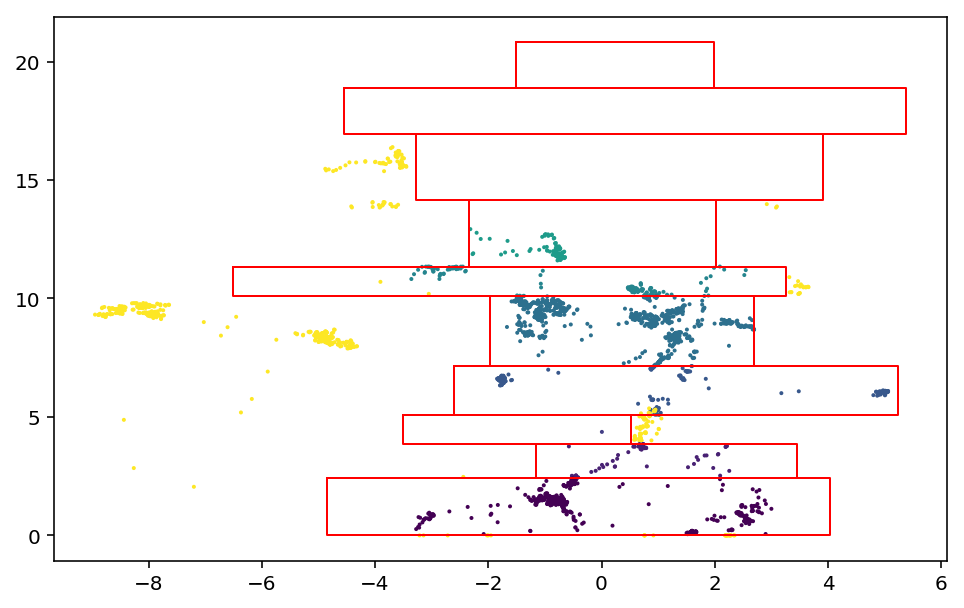

In [66]:
plot_tower_and_all_gazepoints(all_trials_df, tower_id=0, ppid='00', heatmap=False)

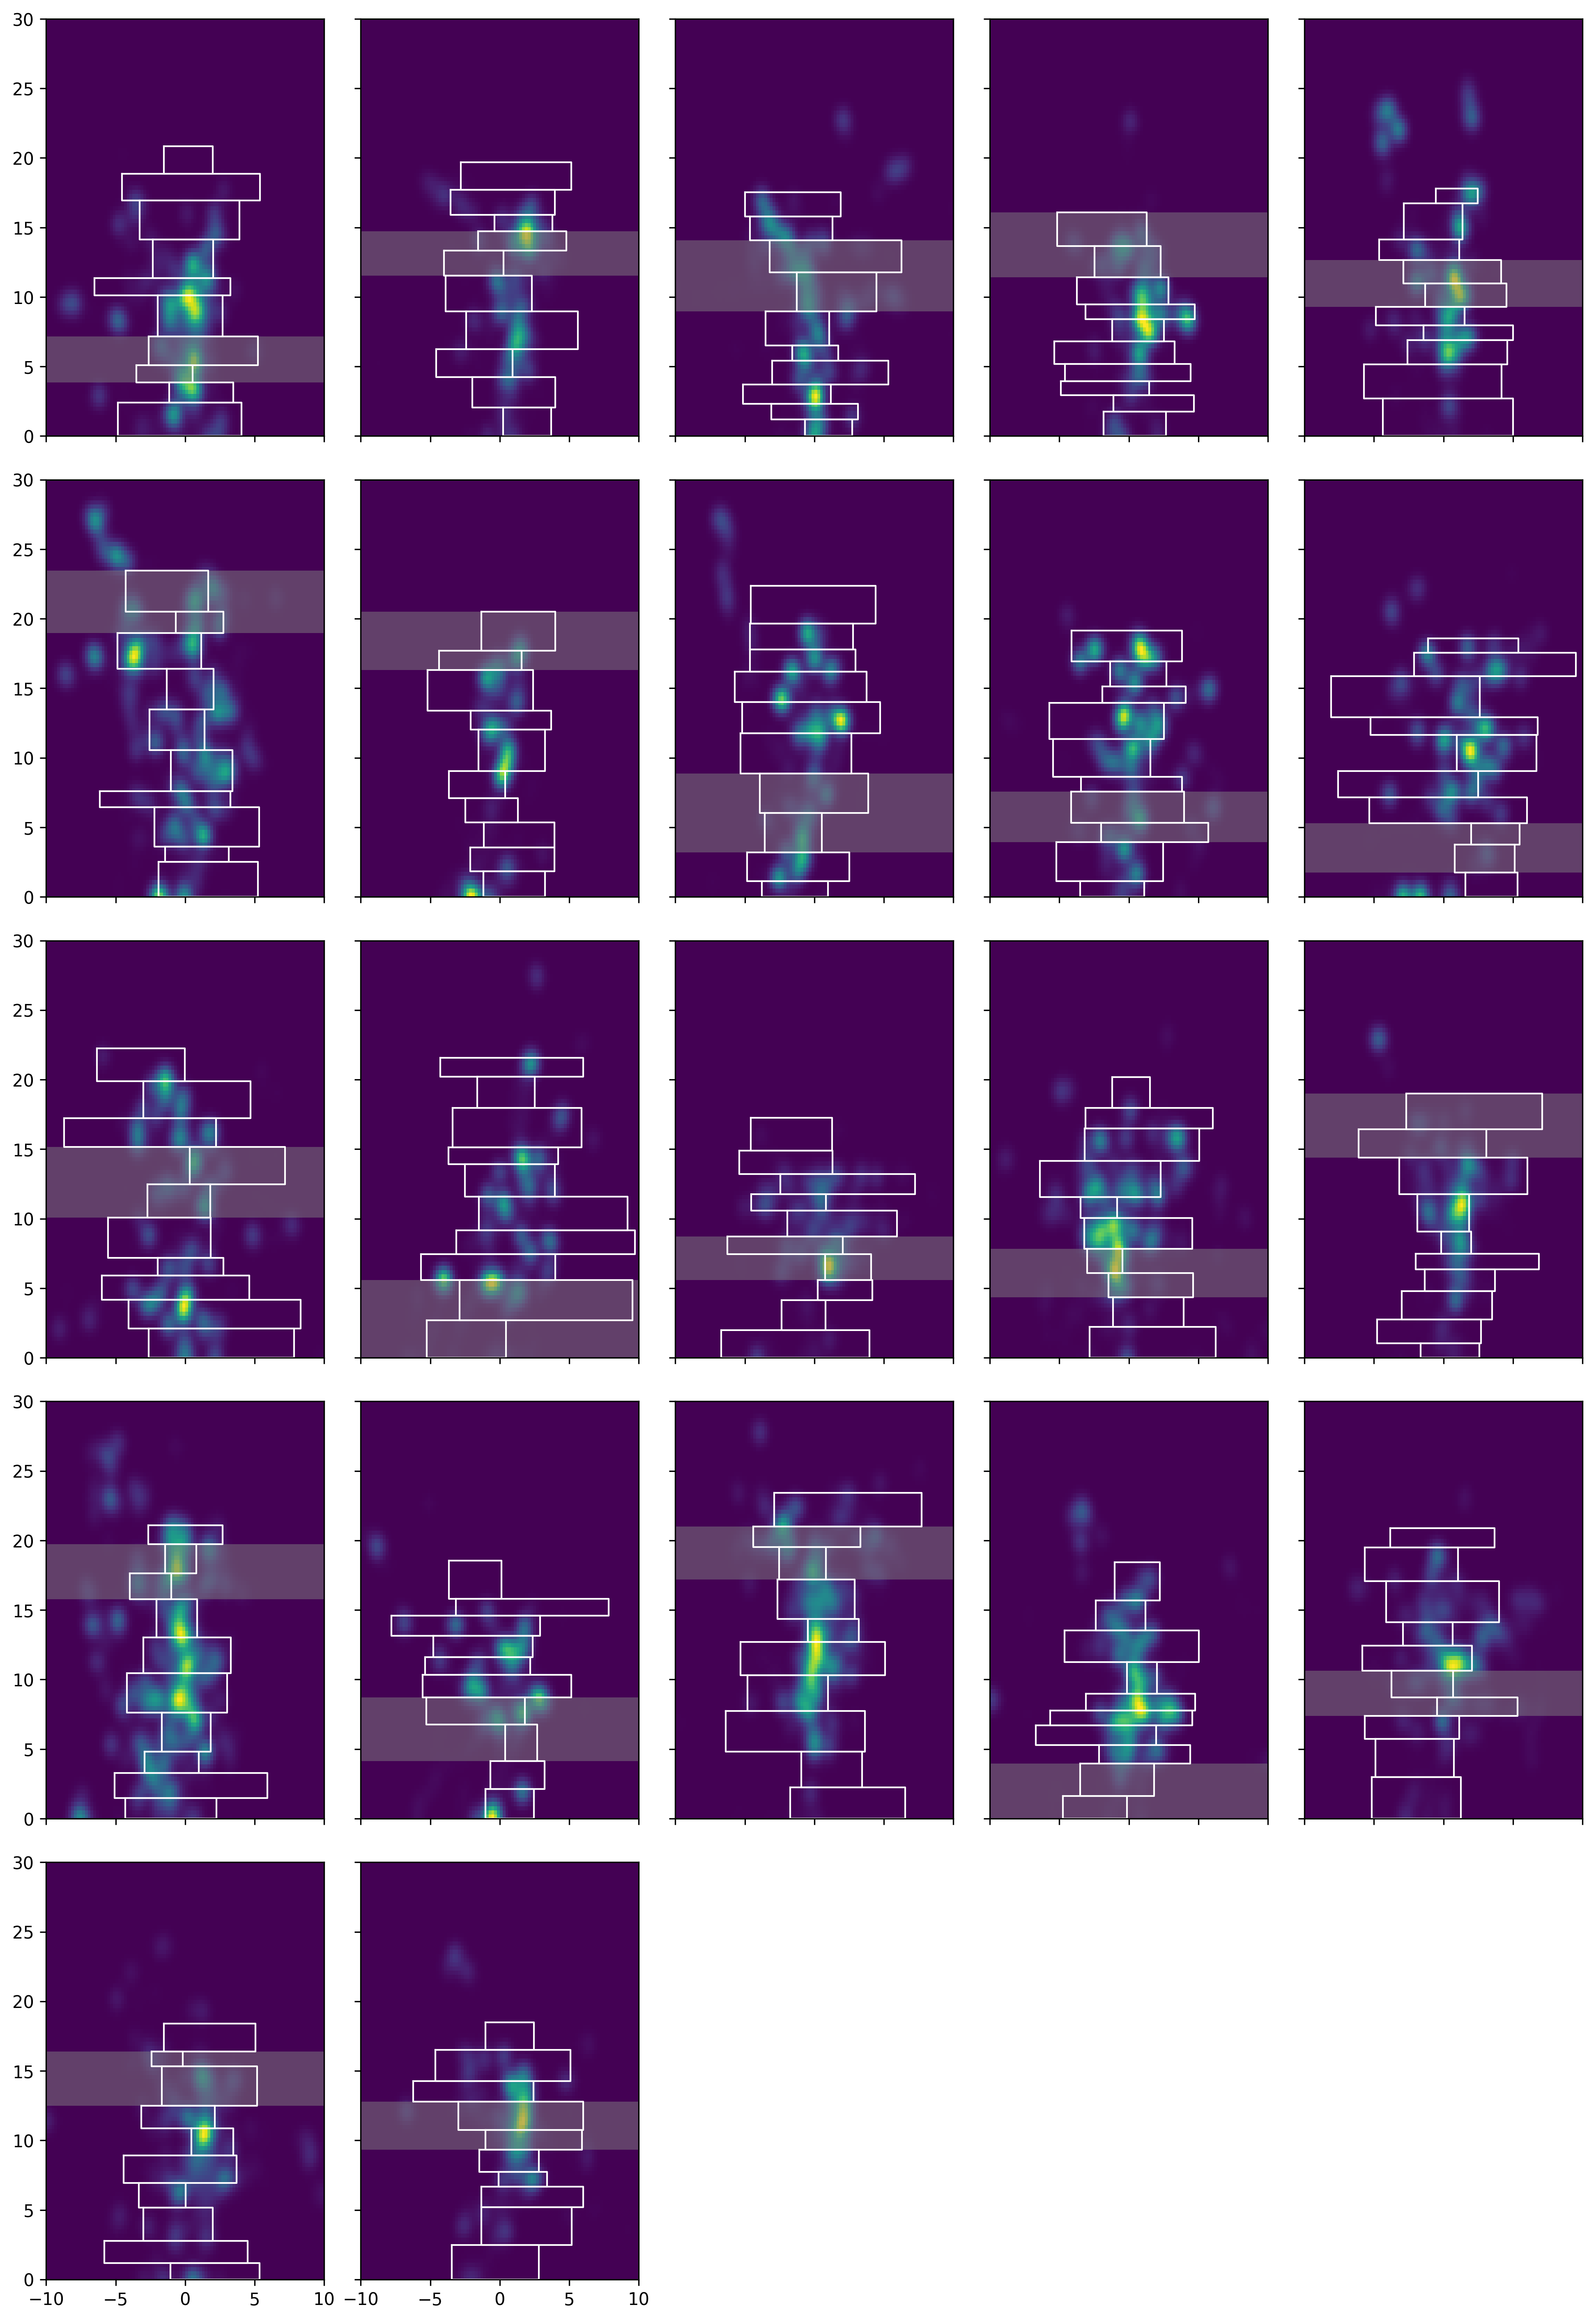

In [138]:
fig, axs = plt.subplots(5, 5, figsize=(13, 19), dpi=300, sharex=True, sharey=True)

for tid, ax in enumerate(fig.axes):
    if tid < 22:
        plot_tower_and_all_gazepoints(all_trials_df, tower_id=tid, with_roi=True, heatmap=True, ax=ax)
    else:
        ax.set_visible(False)

fig.tight_layout()
plt.savefig('figures/all_towers_gaze.png')
plt.show()

R: -0.188570367600663, P: 0.005012380048199936
R: -0.21700176163642554, P: 0.0011994808553497825


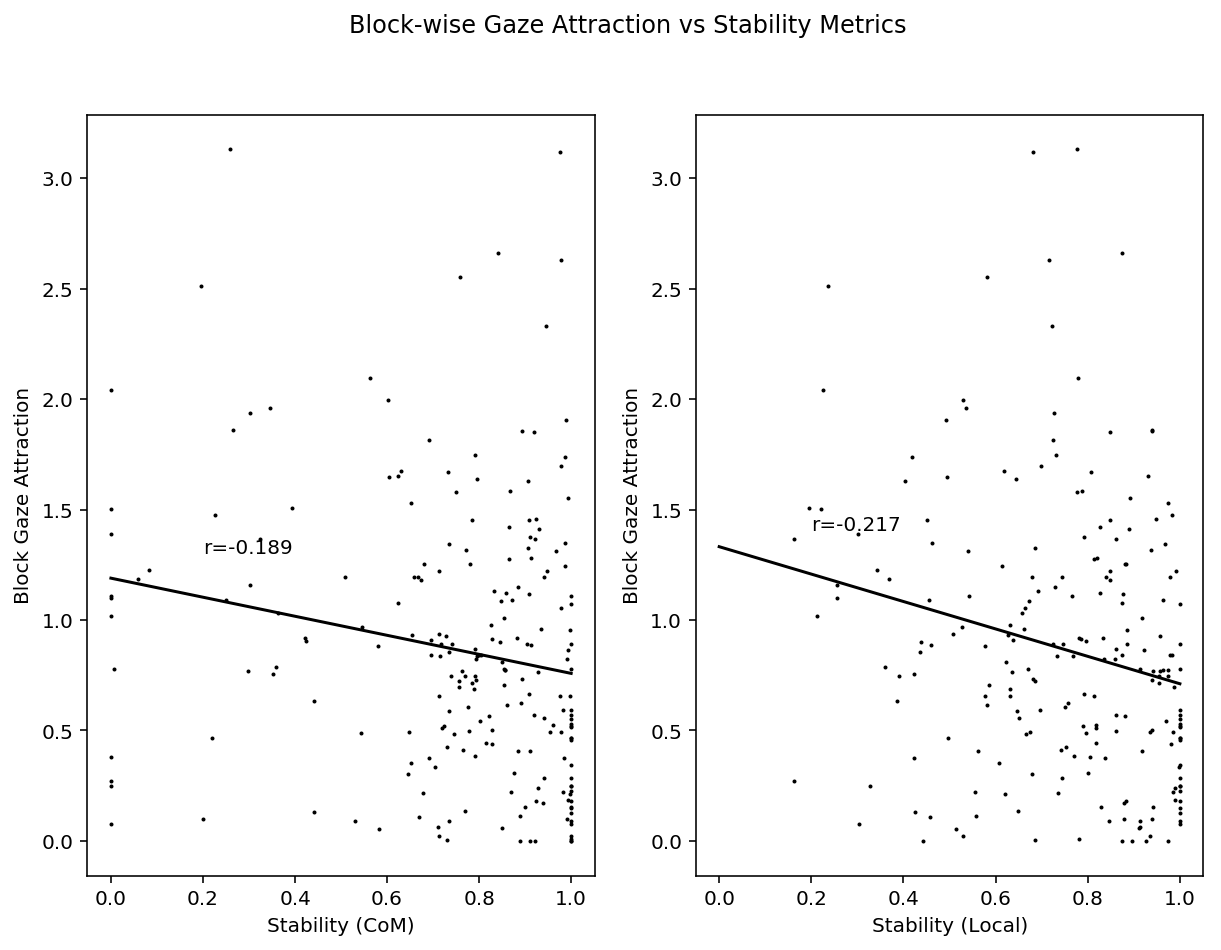

In [140]:
TEXT_GAP = 0.2
fig, axs = plt.subplots(1, 2)
x = block_df.stability_com
y = block_df.hit_pct
axs[0].scatter(x, y, s=1, c='black')
axs[0].set_xlabel("Stability (CoM)")
axs[0].set_ylabel("Block Gaze Attraction")

m, b, r_value, p_value, std_err = stats.linregress(x, y)

print("R: %s, P: %s" % (r_value, p_value))
xaxis = np.array([0, 1])
fit_y = xaxis * m + b
axs[0].plot(xaxis, fit_y, c='black')
axs[0].text(0.2, .2*m+b + TEXT_GAP, "r=%.3f" % r_value)

x = block_df.stability_local
y = block_df.hit_pct
axs[1].scatter(x, y, s=1, c='black')
axs[1].set_xlabel("Stability (Local)")
axs[1].set_ylabel("Block Gaze Attraction")

m, b, r_value, p_value, std_err = stats.linregress(x, y)
print("R: %s, P: %s" % (r_value, p_value))
fit_y = xaxis * m + b
axs[1].plot(xaxis, fit_y, c='black')
axs[1].text(0.2, .2*m+b + TEXT_GAP, "r=%.3f" % r_value)

plt.suptitle("Block-wise Gaze Attraction vs Stability Metrics")
plt.savefig('figures/block_hits_vs_stability.png', dpi=300, figsize=(12, 6))


## Distance from most ambiguous y-pos vs count of gaze points

### TODO: Plot weakest block in trial vs mean distance from weakest point

In [143]:
for idx, row in all_trials_df.iterrows():
    n_in_roi = n_total = 0
    weakest_ypos = tower_df.loc[row.tower, 'weakest_ypos']
    roi_s = tower_df.loc[row.tower, 'roi_s']
    roi_e = tower_df.loc[row.tower, 'roi_e']
    for gp in row.gazepoints:
        if not gp.get('post_response'):
            y = gp.get('y')
            in_roi = y <= roi_e and y >= roi_s
            if in_roi:
                n_in_roi += 1
            n_total += 1
    # ROI: Within y-window of blocks spanning weakest y
    pct_gp_in_roi = n_in_roi / n_total if n_total else 0
    tower_df.loc[row.tower, 'pct_gp_in_roi'] = pct_gp_in_roi

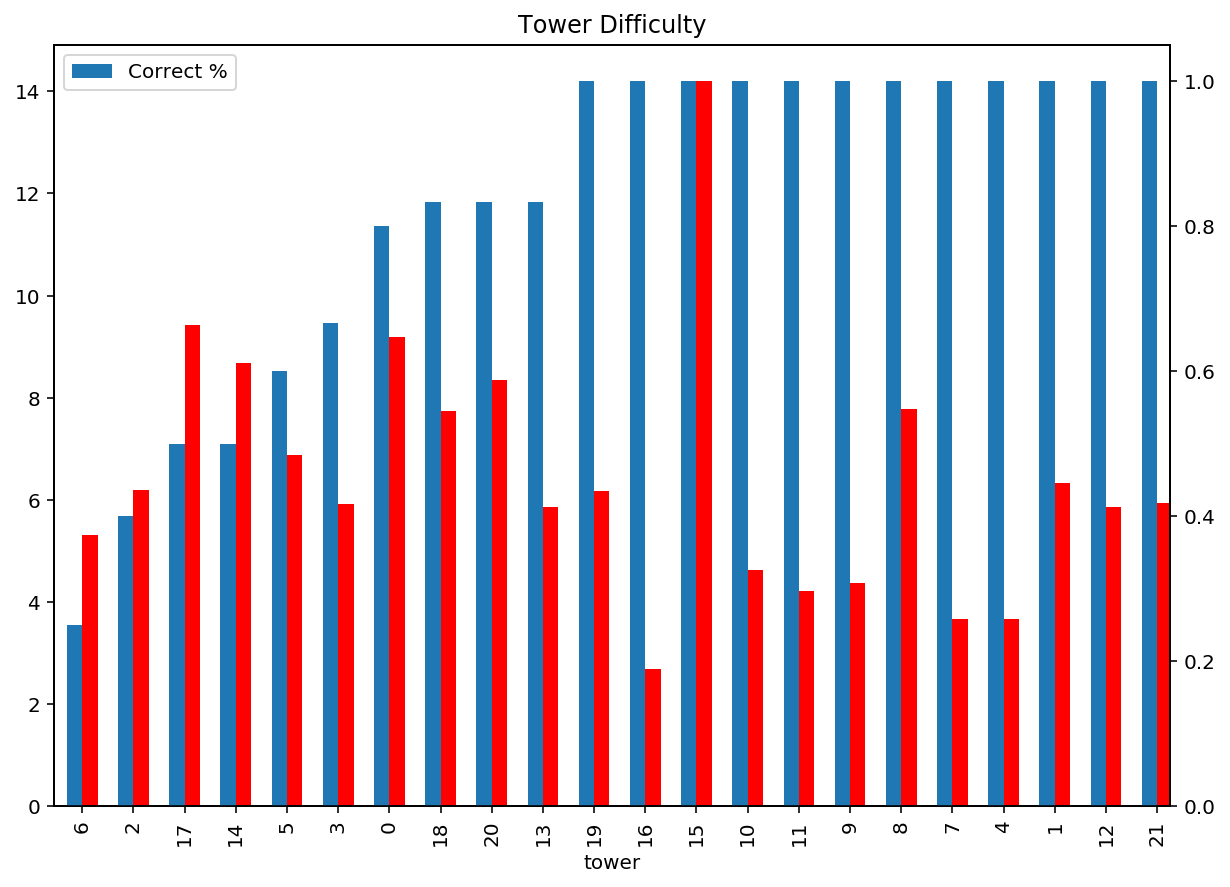

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()

tower_df['response_secs'].plot(kind='bar', label="Mean Response Time (s)", width=0.3, position=0, ax=ax, color='red')
tower_df['pct_correct'].plot(kind='bar', label="Correct %", secondary_y=True, width=0.3, position=1, ax=ax2)
plt.title("Tower Difficulty")
plt.legend()
plt.show()

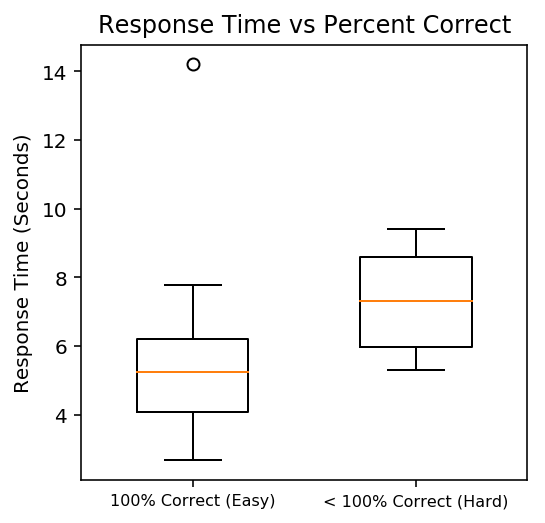

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
everyone_right = tower_df[tower_df['pct_correct'] == 1]
anyone_wrong = tower_df[tower_df['pct_correct'] < 1]
BOXW = 0.5
ax.boxplot([everyone_right['response_secs'], anyone_wrong['response_secs']], widths=BOXW)
ax.set_title("Response Time vs Percent Correct")
ax.set_xticklabels(["100% Correct (Easy)", "< 100% Correct (Hard)"], fontsize=8)
ax.set_ylabel("Response Time (Seconds)")
plt.savefig('figures/rt_pct_correct.png')
plt.show()

Text(0,0.5,'Response Time (s)')

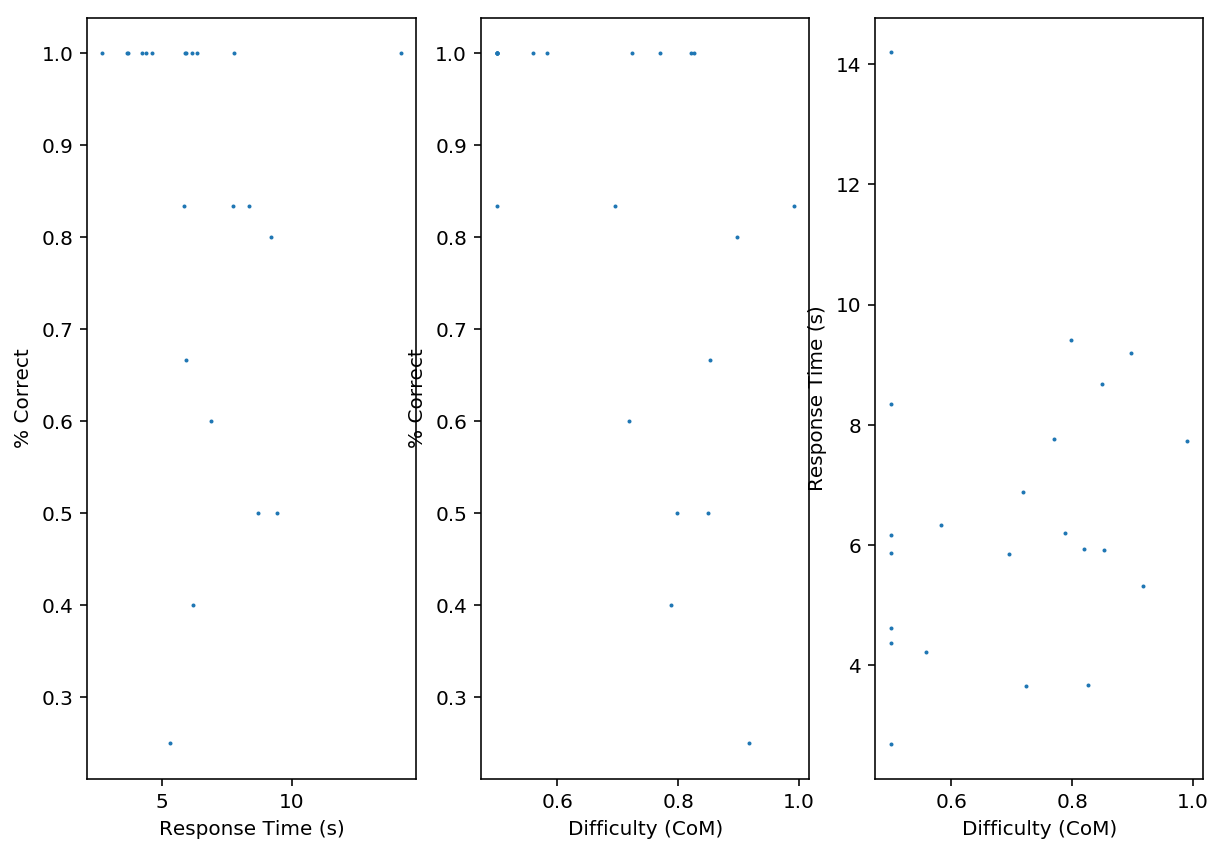

In [114]:
fig, axs = plt.subplots(1, 3)

axs[0].scatter(tower_df['response_secs'], tower_df['pct_correct'], s=1)
axs[0].set_xlabel("Response Time (s)")
axs[0].set_ylabel("% Correct")

axs[1].scatter(tower_df['diff_com_stability'], tower_df['pct_correct'], s=1)
axs[1].set_xlabel("Difficulty (CoM)")
axs[1].set_ylabel("% Correct")

axs[2].scatter(tower_df['diff_com_stability'], tower_df['response_secs'], s=1)
axs[2].set_xlabel("Difficulty (CoM)")
axs[2].set_ylabel("Response Time (s)")

R: -0.5710692336912698, P: 0.005504643981036597


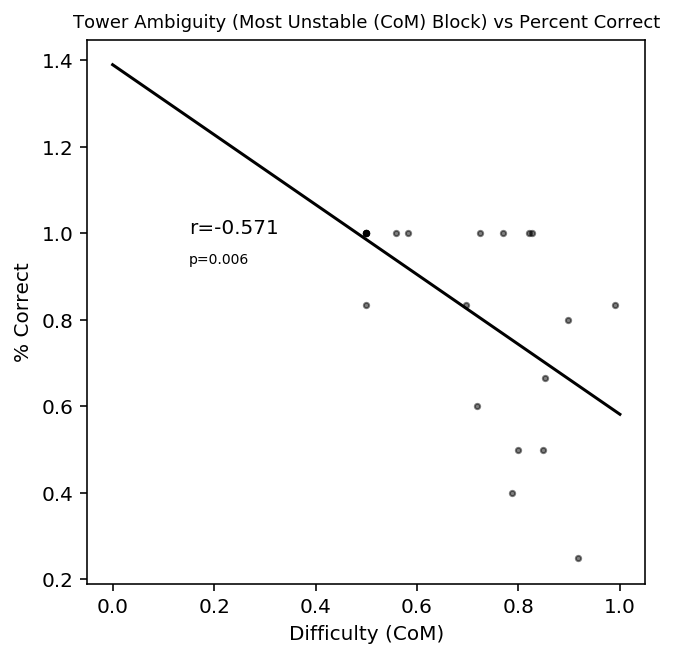

In [133]:
fig, ax = plt.subplots(figsize=(5, 5))
x = tower_df['diff_com_stability']
y = tower_df['pct_correct']
ax.scatter(x, y, s=7, c='black', alpha=0.5)
ax.set_xlabel("Difficulty (CoM)")
ax.set_ylabel("% Correct")

m, b, r_value, p_value, std_err = stats.linregress(x, y)
print("R: %s, P: %s" % (r_value, p_value))
fit_y = xaxis * m + b
ax.plot(xaxis, fit_y, color='black')
TEXTX = .15
ax.text(TEXTX, 1, "r=%.3f" % r_value)
ax.text(TEXTX, .93, "p=%.3f" % p_value, fontsize=7)
plt.title("Tower Ambiguity (Most Unstable (CoM) Block) vs Percent Correct", fontsize=9)
plt.savefig('figures/ambiguity_com_pct_correct.png')
plt.show()


### Distribution of gaze points on ground vs fall left/right decision

In [24]:
X_left = []
Z_left = []
X_right = []
Z_right = []
for idx, row in all_trials_df.iterrows():
    if row.response_int in [-1, 1]:
        # User chooses fall left or right
        for gp in row.gazepoints:
            if not gp.get('post_response') and gp.get('hit_key') == 'ground':
                x = gp.get('x')
                z = gp.get('z')  
                if z > -10:
                    left = row.response_int == -1
                    if left:
                        X_left.append(x)
                        Z_left.append(z)                    
                    else:
                        X_right.append(x)
                        Z_right.append(z)                    

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


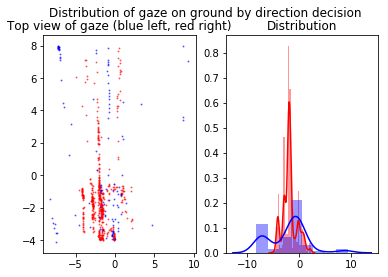

In [25]:
fig, axs = plt.subplots(1, 2)
axs[0].scatter(X_left, Z_left, c='r', s=1, alpha=0.5)
axs[0].scatter(X_right, Z_right, c='b',s=1, alpha=0.5)
axs[0].set_title("Top view of gaze (blue left, red right)")
left_x_mean = np.array(X_left).mean()
right_x_mean = np.array(X_right).mean()
sns.distplot(X_left, color='red', ax=axs[1])
sns.distplot(X_right, color='blue', ax=axs[1])
axs[1].set_title("Distribution")
# axs[1].bar([0, 1], [left_x_mean, right_x_mean])
plt.suptitle("Distribution of gaze on ground by direction decision")

plt.show()

In [26]:
X_fall = []
Y_fall = []
X_notfall = []
Y_notfall = []
for idx, row in all_trials_df.iterrows():
    for gp in row.gazepoints:
        if not gp.get('post_response'):
            x = gp.get('x')
            y = gp.get('y')  
            fall = row.predict_fall
            if fall:
                X_fall.append(x)
                Y_fall.append(y)                    
            else:
                X_notfall.append(x)
                Y_notfall.append(y)                    

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


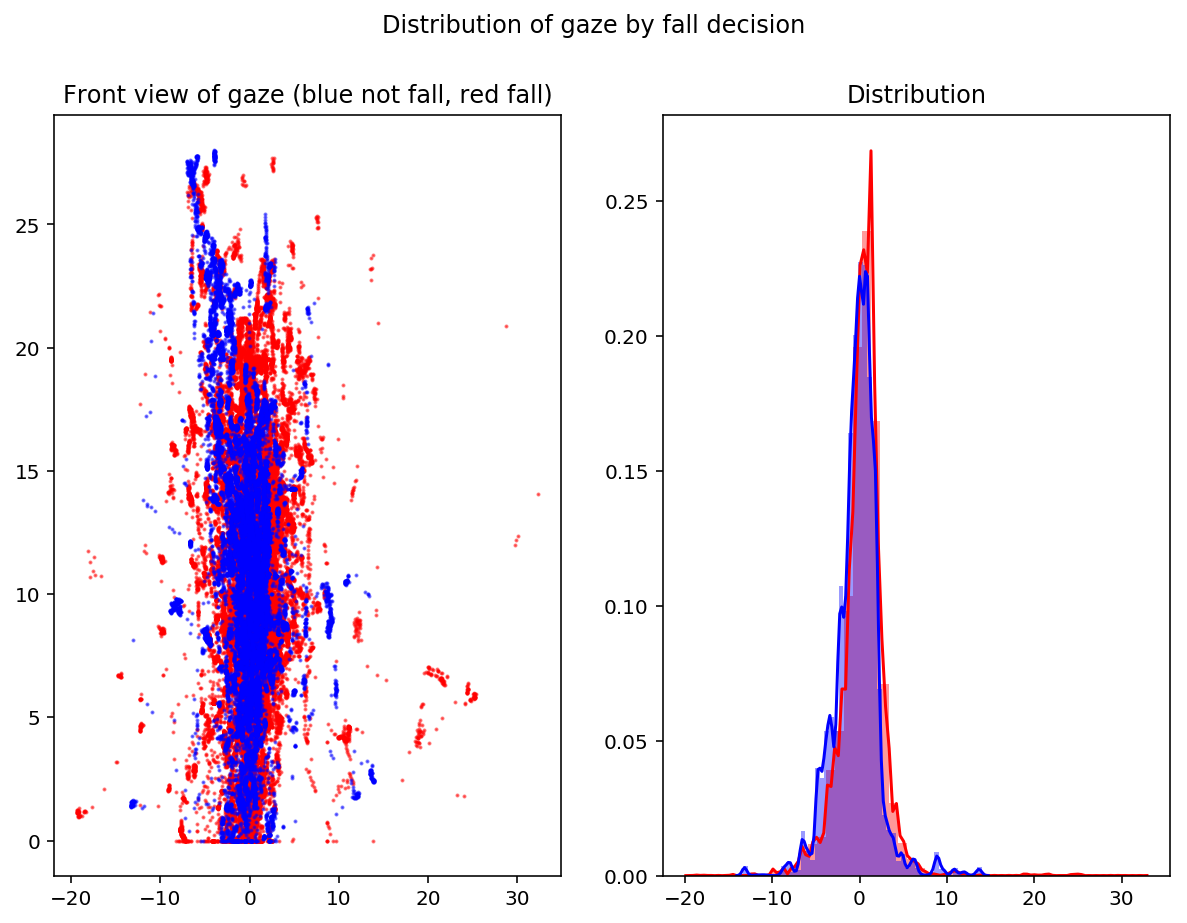

In [244]:
fig, axs = plt.subplots(1, 2)
axs[0].scatter(X_fall, Y_fall, c='r', s=1, alpha=0.5)
axs[0].scatter(X_notfall, Y_notfall, c='b',s=1, alpha=0.5)
axs[0].set_title("Front view of gaze (blue not fall, red fall)")
sns.distplot(X_fall, color='red', ax=axs[1])
sns.distplot(X_notfall, color='blue', ax=axs[1])
axs[1].set_title("Distribution")
# axs[1].bar([0, 1], [left_x_mean, right_x_mean])
plt.suptitle("Distribution of gaze by fall decision")

plt.show()

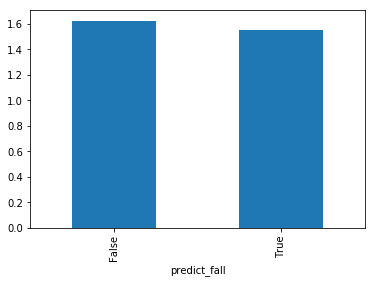

In [28]:
all_trials_df.groupby('predict_fall').block_hit_entropy.mean().plot.bar()

### Towers by block stability & ambiguity

In [25]:
tower_df

,pct_correct,response_secs,stability,weakest_ypos,roi_s,roi_e,most_local_unstable_block_idx,most_local_unstable_block,most_com_unstable_block_idx,most_com_unstable_block,com_stabilities,diff_local_stability,diff_com_stability,weakest_ypospct_gp_in_roi,pct_gp_in_roi
tower,,,,,,,,,,,,,,,
15,1.00,16.216059,0.739779,17.625057,15.782232,19.729178,7.0,0.162699,7.0,0.083614,"0.9117957125063089,0.8833964909410398,0.846501...",0.662699,0.583614,0.284864,0.284864
9,1.00,4.353594,0.675092,1.738917,0.000000,3.768186,4.0,0.194409,0.0,0.272210,"0.2722102281820139,0.3320670703966446,0.526462...",0.694409,0.772210,0.182181,0.182181
20,0.80,8.593985,0.638910,16.401065,15.320700,18.409660,8.0,0.303349,8.0,0.303349,"0.7784241954961761,0.8515543550590908,0.727492...",0.803349,0.803349,0.016041,0.016041
19,1.00,6.676348,0.743479,8.725157,7.371380,10.630464,3.0,0.225130,3.0,0.308595,"0.8574116820902088,0.8194483133655055,0.765642...",0.725130,0.808595,0.104301,0.104301
16,1.00,2.703743,0.754659,4.142879,2.128742,6.776383,2.0,0.301415,1.0,0.351815,"0.6503085951804815,0.3518150120001966,0.482848...",0.801415,0.851815,0.170854,0.170854
10,1.00,5.133364,0.642869,15.148029,12.476045,17.222346,6.0,0.212759,6.0,0.375688,"0.7514644359706844,0.7572401697989251,0.999276...",0.712759,0.875688,0.403423,0.403423
12,1.00,6.426864,0.597749,5.575819,4.128841,7.459872,1.0,0.161375,2.0,0.388112,"0.7909545690110795,0.7434421727232604,0.388111...",0.661375,0.888112,0.452402,0.452402
1,1.00,6.867759,0.719836,13.337655,11.528439,14.717769,5.0,0.343004,5.0,0.454173,"0.6668692244517815,0.8791110592162004,0.644519...",0.843004,0.954173,0.224784,0.224784
5,0.75,6.173548,0.673626,20.500580,18.957979,23.457814,7.0,0.385851,8.0,0.495803,"0.6984740663208228,0.8346308515976264,0.744996...",0.885851,0.995803,0.345052,0.345052


In [169]:
med = tower_df.most_com_unstable_block.mean()
med

0.33727933809537397

In [184]:
AR = (med-0.25, med+0.25)

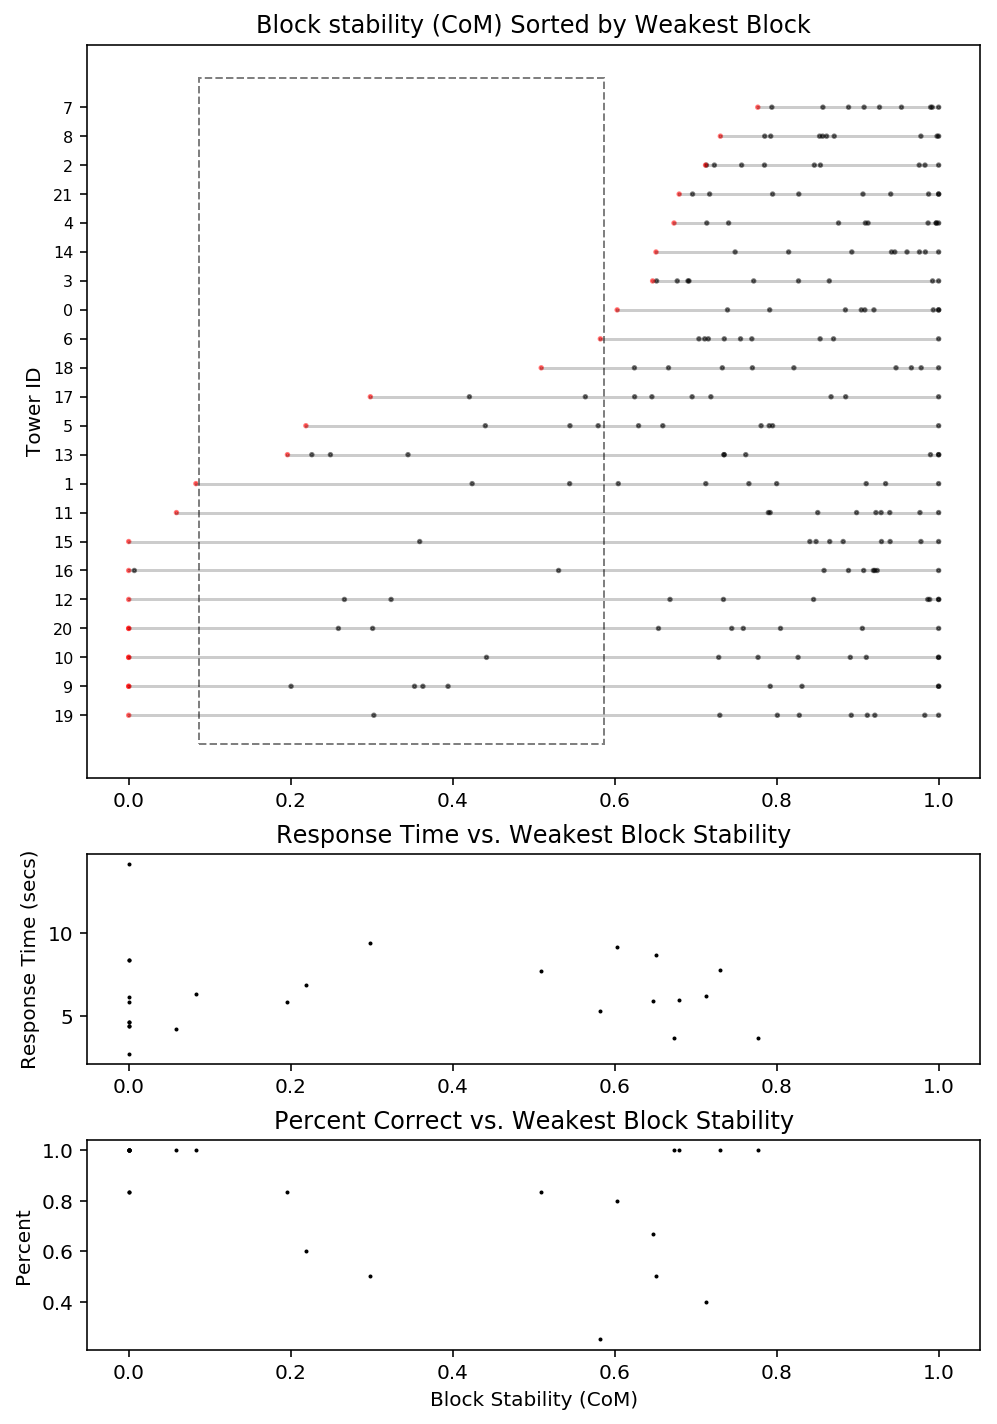

In [287]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(3, 1, hspace=0.2, height_ratios=[3.5, 1, 1])

X = []
Y = []
COLOR = []

# Plot 2
RT_X = []
RT_Y = []

# Plot 3
PCTC_X, PCTC_Y = [], []

# Plot 4
PCT_ROI_X, PCT_ROI_Y = [], []

STABILITY_TYPE = 'com'  # 'com'

fig = plt.figure(figsize=(8, 12))

tower_df = tower_df.sort_values('most_%s_unstable_block' % STABILITY_TYPE)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)

# Block weakness for each tower
sorted_id = 1
for id, row in tower_df.iterrows():
    stabilities = [float(x) for x in row['%s_stabilities' % STABILITY_TYPE].split(',')]
    least_stable = None
    for block_stab in stabilities:
        most_unstable = block_stab == row['most_%s_unstable_block' % STABILITY_TYPE]
        X.append(block_stab)
        Y.append(sorted_id)
        COLOR.append('r' if most_unstable else 'black')
        if most_unstable:
            RT_X.append(block_stab)
            RT_Y.append(row.response_secs)
            PCTC_X.append(block_stab)
            PCTC_Y.append(row.pct_correct)
            PCT_ROI_X.append(block_stab)
            PCT_ROI_Y.append(row.pct_gp_in_roi)
            least_stable = block_stab
    ax0.plot([least_stable, 1], [sorted_id, sorted_id], color='black', alpha=0.2)
    sorted_id += 1

MAX_Y = len(tower_df)+1

rect = patches.Rectangle((AR[0],0),AR[1] - AR[0],MAX_Y, color='gray', fill=False, linestyle='--')
ax0.add_patch(rect)
ax0.set_title("Block stability (CoM) Sorted by Weakest Block")
ax0.scatter(X, Y, c=COLOR, s=3, alpha=0.5)
ax0.set_ylabel("Tower ID")
ax0.set_yticks(range(1, MAX_Y))
ax0.set_yticklabels(tower_df.index, fontsize=8)

ax1.scatter(RT_X, RT_Y, c='black', s=1)
ax1.set_title("Response Time vs. Weakest Block Stability")
ax1.set_ylabel("Response Time (secs)")

ax2.scatter(PCTC_X, PCTC_Y, c='black', s=1)
ax2.set_title("Percent Correct vs. Weakest Block Stability")
ax2.set_ylabel("Percent")
ax2.set_xlabel("Block Stability (CoM)")

# axs[3].scatter(PCT_ROI_X, PCT_ROI_Y)
# axs[3].set_title("% Gaze in ROI")
plt.savefig('figures/weakest_block_stabilities.png')
plt.show()

In [186]:

tower_df['ambiguous'] = (tower_df.most_com_unstable_block > AR[0]) & (tower_df.most_com_unstable_block < AR[1])


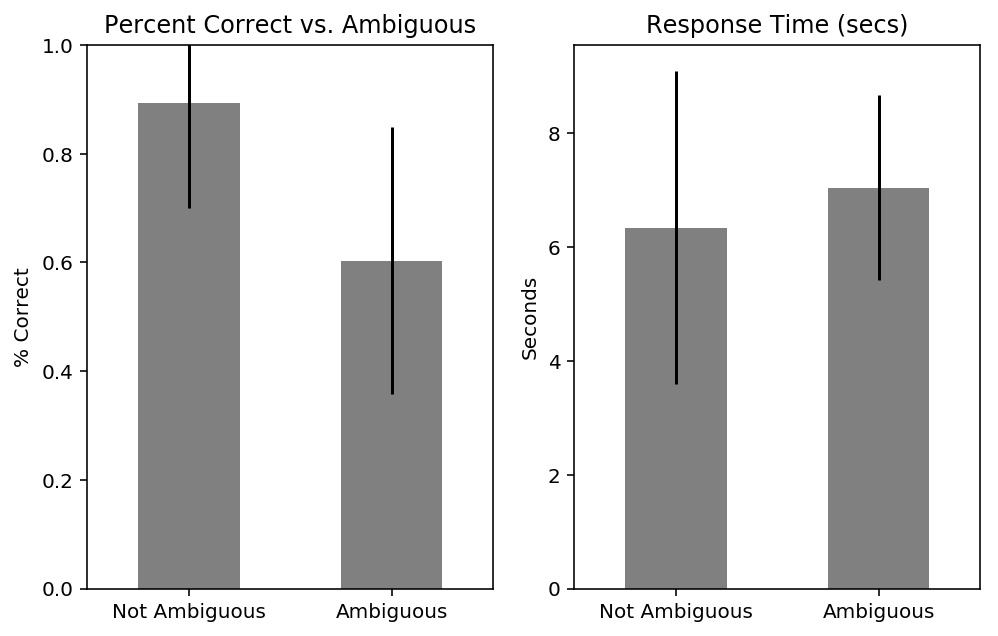

In [282]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

ax = axs[0]
ax.set_ylim((0, 1))
errors = tower_df.groupby('ambiguous').pct_correct.std()
tower_df.groupby('ambiguous').pct_correct.mean().plot.bar(color='gray', yerr=errors, ax=ax, rot=0)
ax.set_xticklabels(["Not Ambiguous", "Ambiguous"])
ax.set_ylabel("% Correct")
ax.set_xlabel('')
ax.set_title("Percent Correct vs. Ambiguous")

ax = axs[1]
errors = tower_df.groupby('ambiguous').response_secs.std()
tower_df.groupby('ambiguous').response_secs.mean().plot.bar(color='gray', yerr=errors, ax=ax, rot=0)
ax.set_title("Response Time (secs)")
ax.set_ylabel("Seconds")
ax.set_xticklabels(["Not Ambiguous", "Ambiguous"])
ax.set_xlabel('')

plt.savefig('figures/ambiguity_and_difficulty.png')


Text(0.5,1,'% gaze points in ROI versus ambiguous')

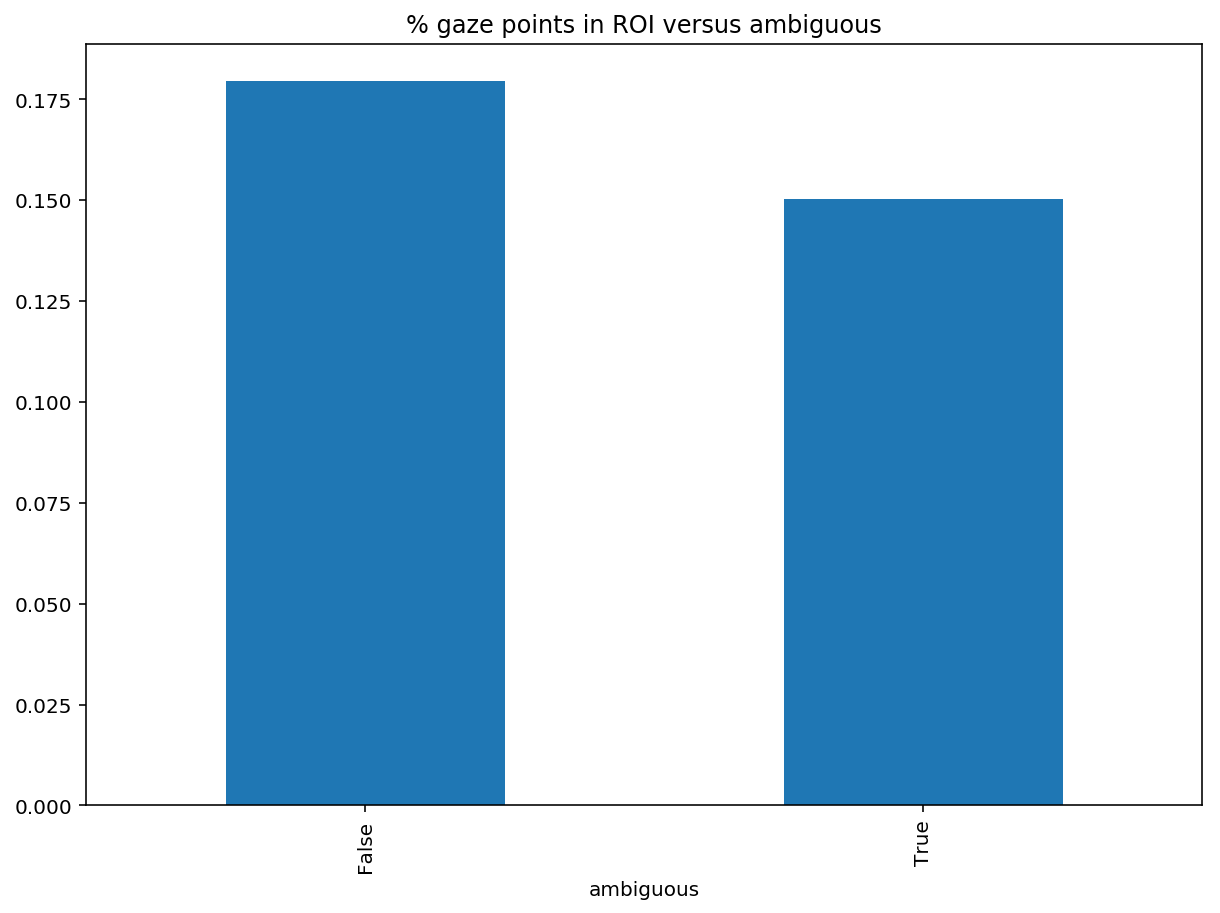

In [188]:
tower_df.groupby('ambiguous').pct_gp_in_roi.mean().plot.bar(color='black', ax=ax)
ax.set_title("Percent of Gaze in ROI vs Ambiguous")
ax.set_xticklabels(["Ambiguous", "Not Ambiguous"])
ax.set_xlabel('')

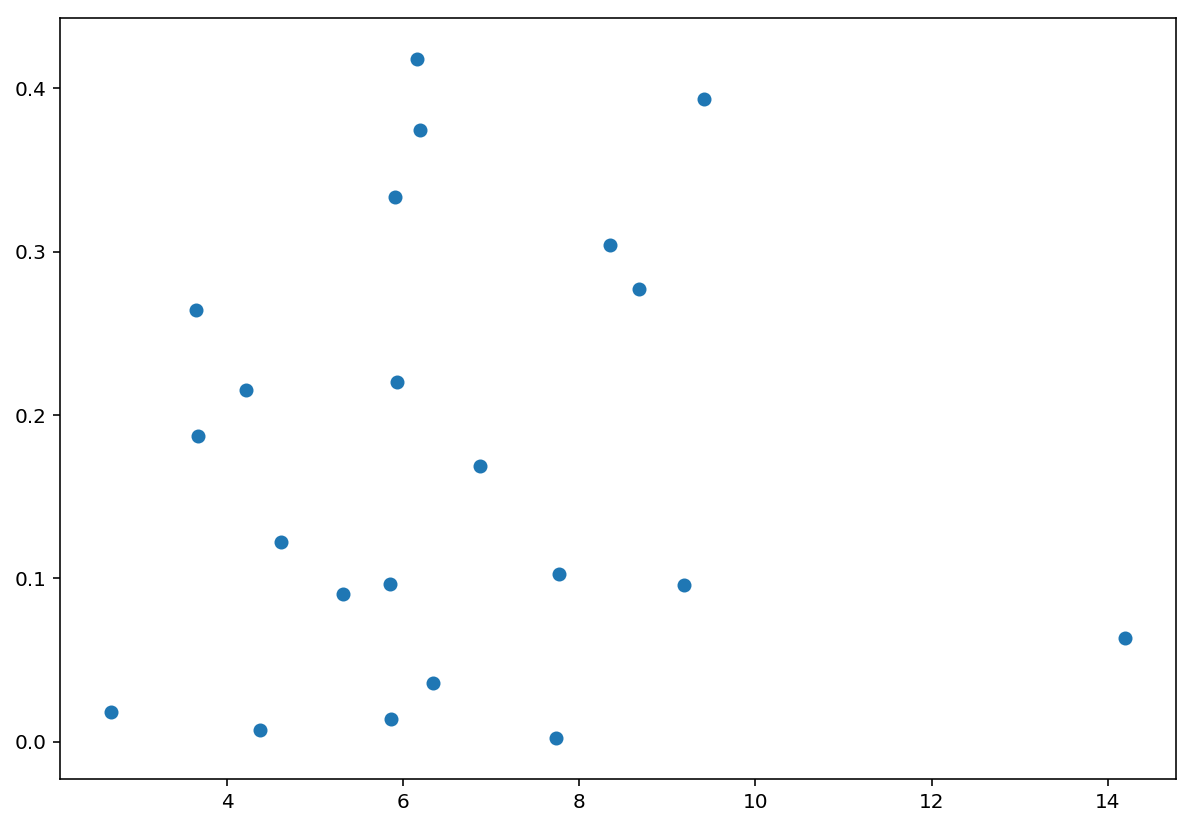

In [189]:
x = tower_df.response_secs
y = tower_df.pct_gp_in_roi

m,b = np.polyfit(x, y, 1)

plt.scatter(x, y)
xaxis = np.arange(min(x), 1, 0.1)
fit_y = xaxis * m + b
plt.plot(xaxis, fit_y)
plt.show()



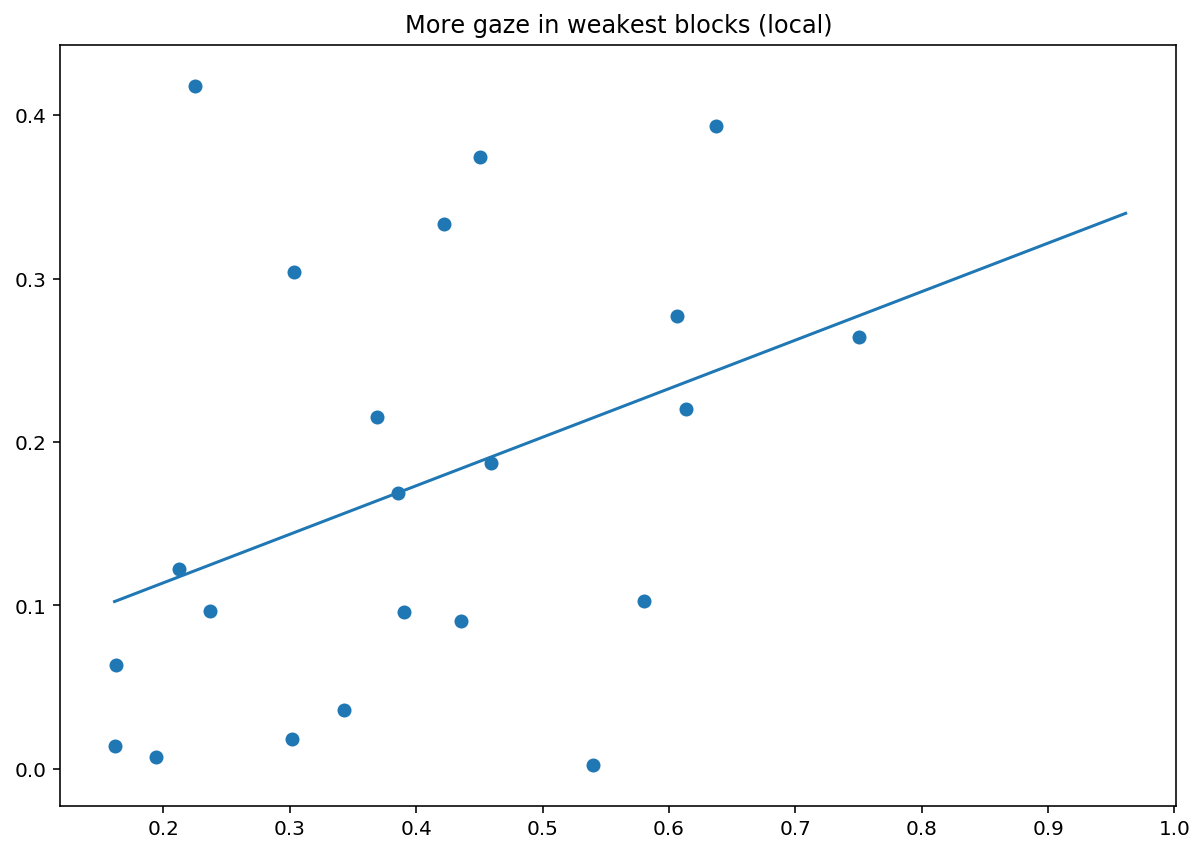

In [233]:
x = tower_df.most_local_unstable_block
y = tower_df.pct_gp_in_roi

m,b = np.polyfit(x, y, 1)

plt.scatter(x, y)
xaxis = np.arange(min(x), 1, 0.1)
fit_y = xaxis * m + b
plt.plot(xaxis, fit_y)
plt.title("More gaze in weakest blocks (local)")
plt.show()


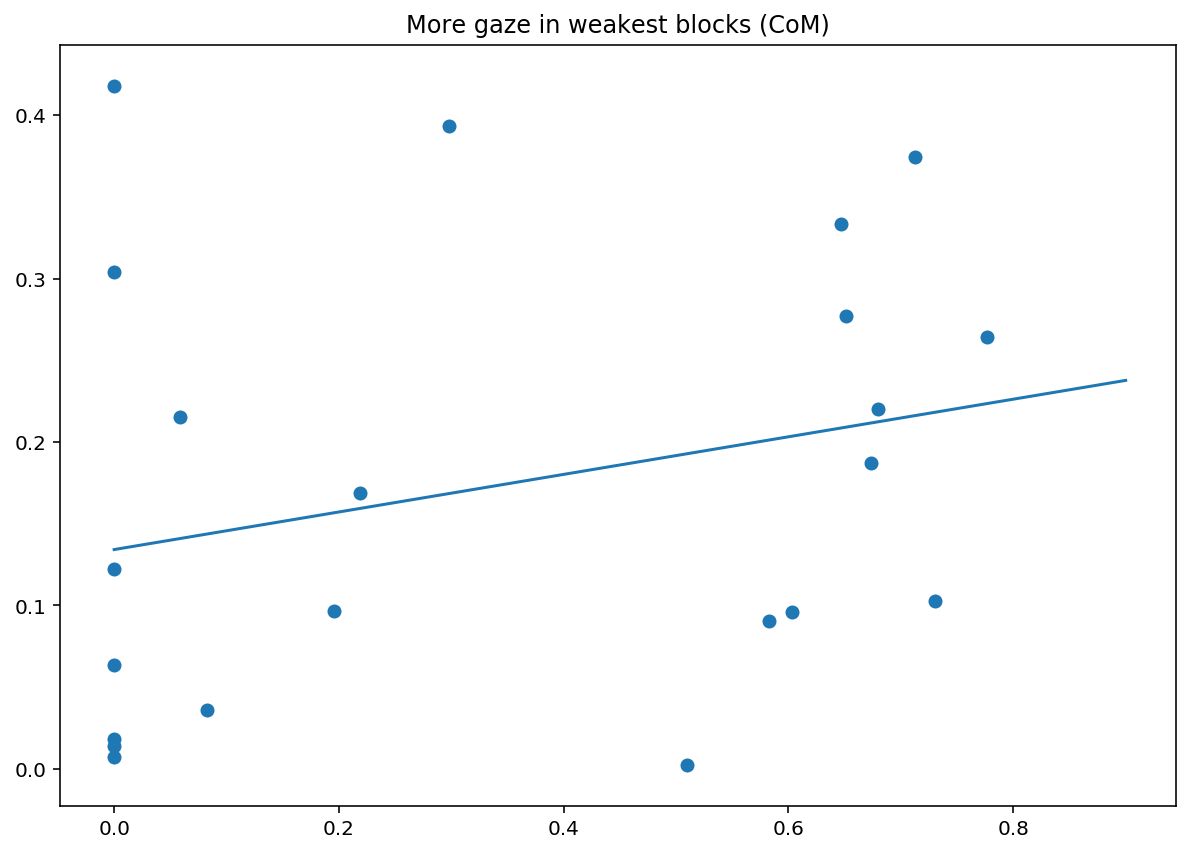

In [234]:
x = tower_df.most_com_unstable_block
y = tower_df.pct_gp_in_roi

m,b = np.polyfit(x, y, 1)

plt.scatter(x, y)
xaxis = np.arange(min(x), 1, 0.1)
fit_y = xaxis * m + b
plt.plot(xaxis, fit_y)
plt.title("More gaze in weakest blocks (CoM)")
plt.show()


<BarContainer object of 10 artists>

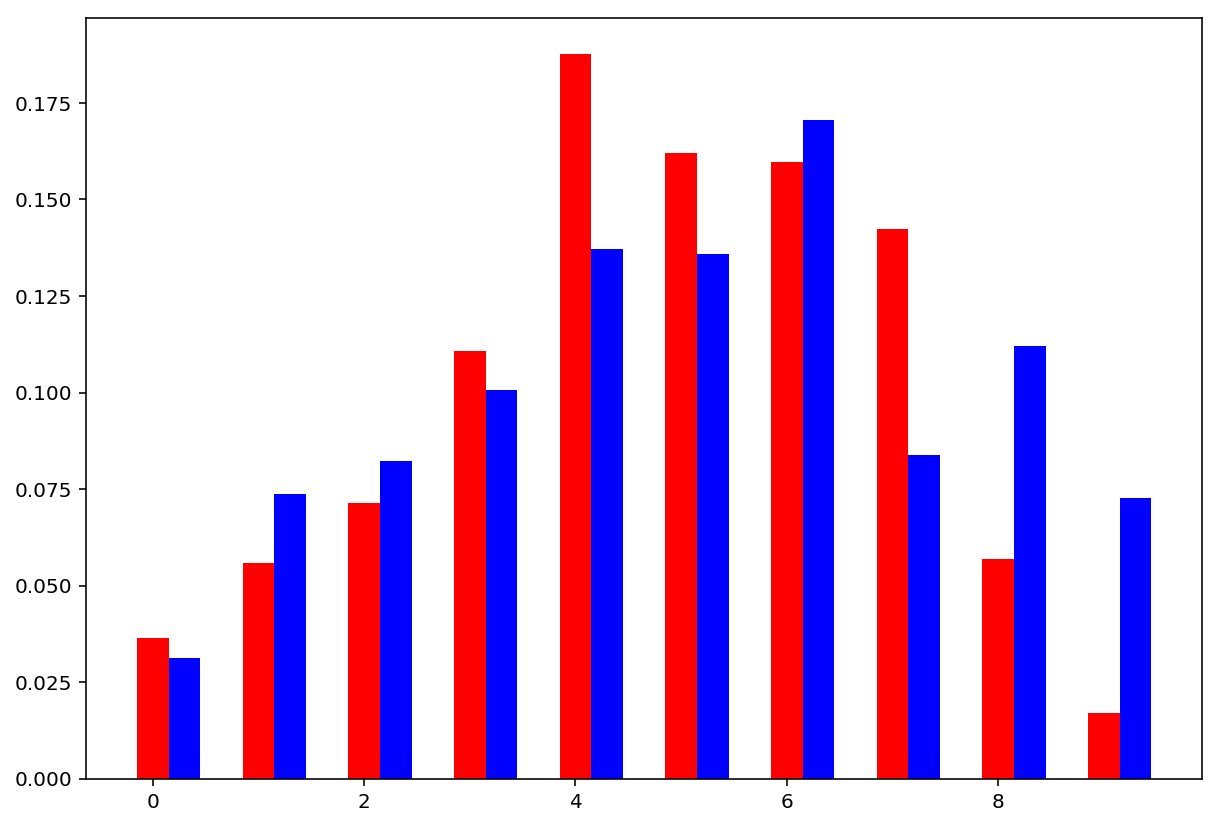

In [89]:
fall_dist = np.zeros(10)
notfall_dist = np.zeros(10)
for tid, row in all_trials_df.iterrows():
    if str(row.block_hit_pcts[0]) != 'nan':
        if row.predict_fall:
            fall_dist += row.block_hit_pcts
        else:
            notfall_dist += row.block_hit_pcts
xaxis = np.array(range(10))
plt.bar(xaxis, fall_dist / fall_dist.sum(), color='red', width=0.3)
plt.bar(xaxis + 0.3, notfall_dist / notfall_dist.sum(), color='blue', width=0.3)

In [93]:
?plt.bar

## Most contentious towers, view gaze

In [280]:
def gaze_response_comparison_one_tower(tower_id=17):
    X_fall_right = []
    Y_fall_right = []
    X_fall_left = []
    Y_fall_left = []
    X_notfall = []
    Y_notfall = []
    for idx, row in all_trials_df[all_trials_df.tower == tower_id].iterrows():
        for gp in row.gazepoints:
            if not gp.get('post_response'):
                x = gp.get('x')
                y = gp.get('y')  
                ri = row.response_int
                if ri == -1:
                    X_fall_left.append(x)
                    Y_fall_left.append(y)                    
                elif ri == 1:
                    X_fall_right.append(x)
                    Y_fall_right.append(y)                    
                else:
                    X_notfall.append(x)
                    Y_notfall.append(y)     

    fig, axs = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
    ax = axs[0]
    plot_tower(tower_id, ax=ax)
    ax.scatter(X_fall_left, Y_fall_left, c='orange', s=1, alpha=0.3, label="Left")
    ax.scatter(X_fall_right, Y_fall_right, c='red', s=1, alpha=0.3, label="Right")
    ax.scatter(X_notfall, Y_notfall, c='b',s=1, alpha=0.3, label="Not Fall")
    ax.set_title("Front view of gaze", fontsize=10)
    ax.legend()
    # (blue not fall, orange left, red right)
    
    ax = axs[1]
    sns.distplot(X_fall_left, color='orange', ax=ax)
    sns.distplot(X_fall_right, color='red', ax=ax)
    sns.distplot(X_notfall, color='blue', ax=ax)

    ax.set_title("Gaze-x distribution", fontsize=10)
    # axs[1].bar([0, 1], [left_x_mean, right_x_mean])

    DIRS = ["Left", "Right", "Not Fall"]

#     axs[1][0].bar(range(3), [
#         np.std(X_fall_left),
#         np.std(X_fall_right),
#         np.std(X_notfall)    
#     ])
#     axs[1][0].set_xticks(range(3))
#     axs[1][0].set_xticklabels(DIRS)
#     axs[1][0].set_title("Std Dev (X)")

#     axs[1][1].bar(range(3), [
#         np.mean(X_fall_left),
#         np.mean(X_fall_right),
#         np.mean(X_notfall)    
#     ])
#     axs[1][1].set_xticks(range(3))
#     axs[1][1].set_xticklabels(DIRS)
#     axs[1][1].set_title("Mean (X)")

#     axs[2][0].bar(range(3), [
#         np.std(Y_fall_left),
#         np.std(Y_fall_right),
#         np.std(Y_notfall)    
#     ])
#     axs[2][0].set_xticks(range(3))
#     axs[2][0].set_xticklabels(DIRS)
#     axs[2][0].set_title("Std Dev (Y)")

#     axs[2][1].bar(range(3), [
#         np.mean(Y_fall_left),
#         np.mean(Y_fall_right),
#         np.mean(Y_notfall)    
#     ])
#     axs[2][1].set_xticks(range(3))
#     axs[2][1].set_xticklabels(DIRS)
#     axs[2][1].set_title("Mean (Y)")

    plt.suptitle("Distribution of Gaze by Fall Decision (Tower #%d)" % tower_id)
    plt.savefig('figures/response_gaze_comp_%d.png' % tower_id)
    plt.show()                 

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


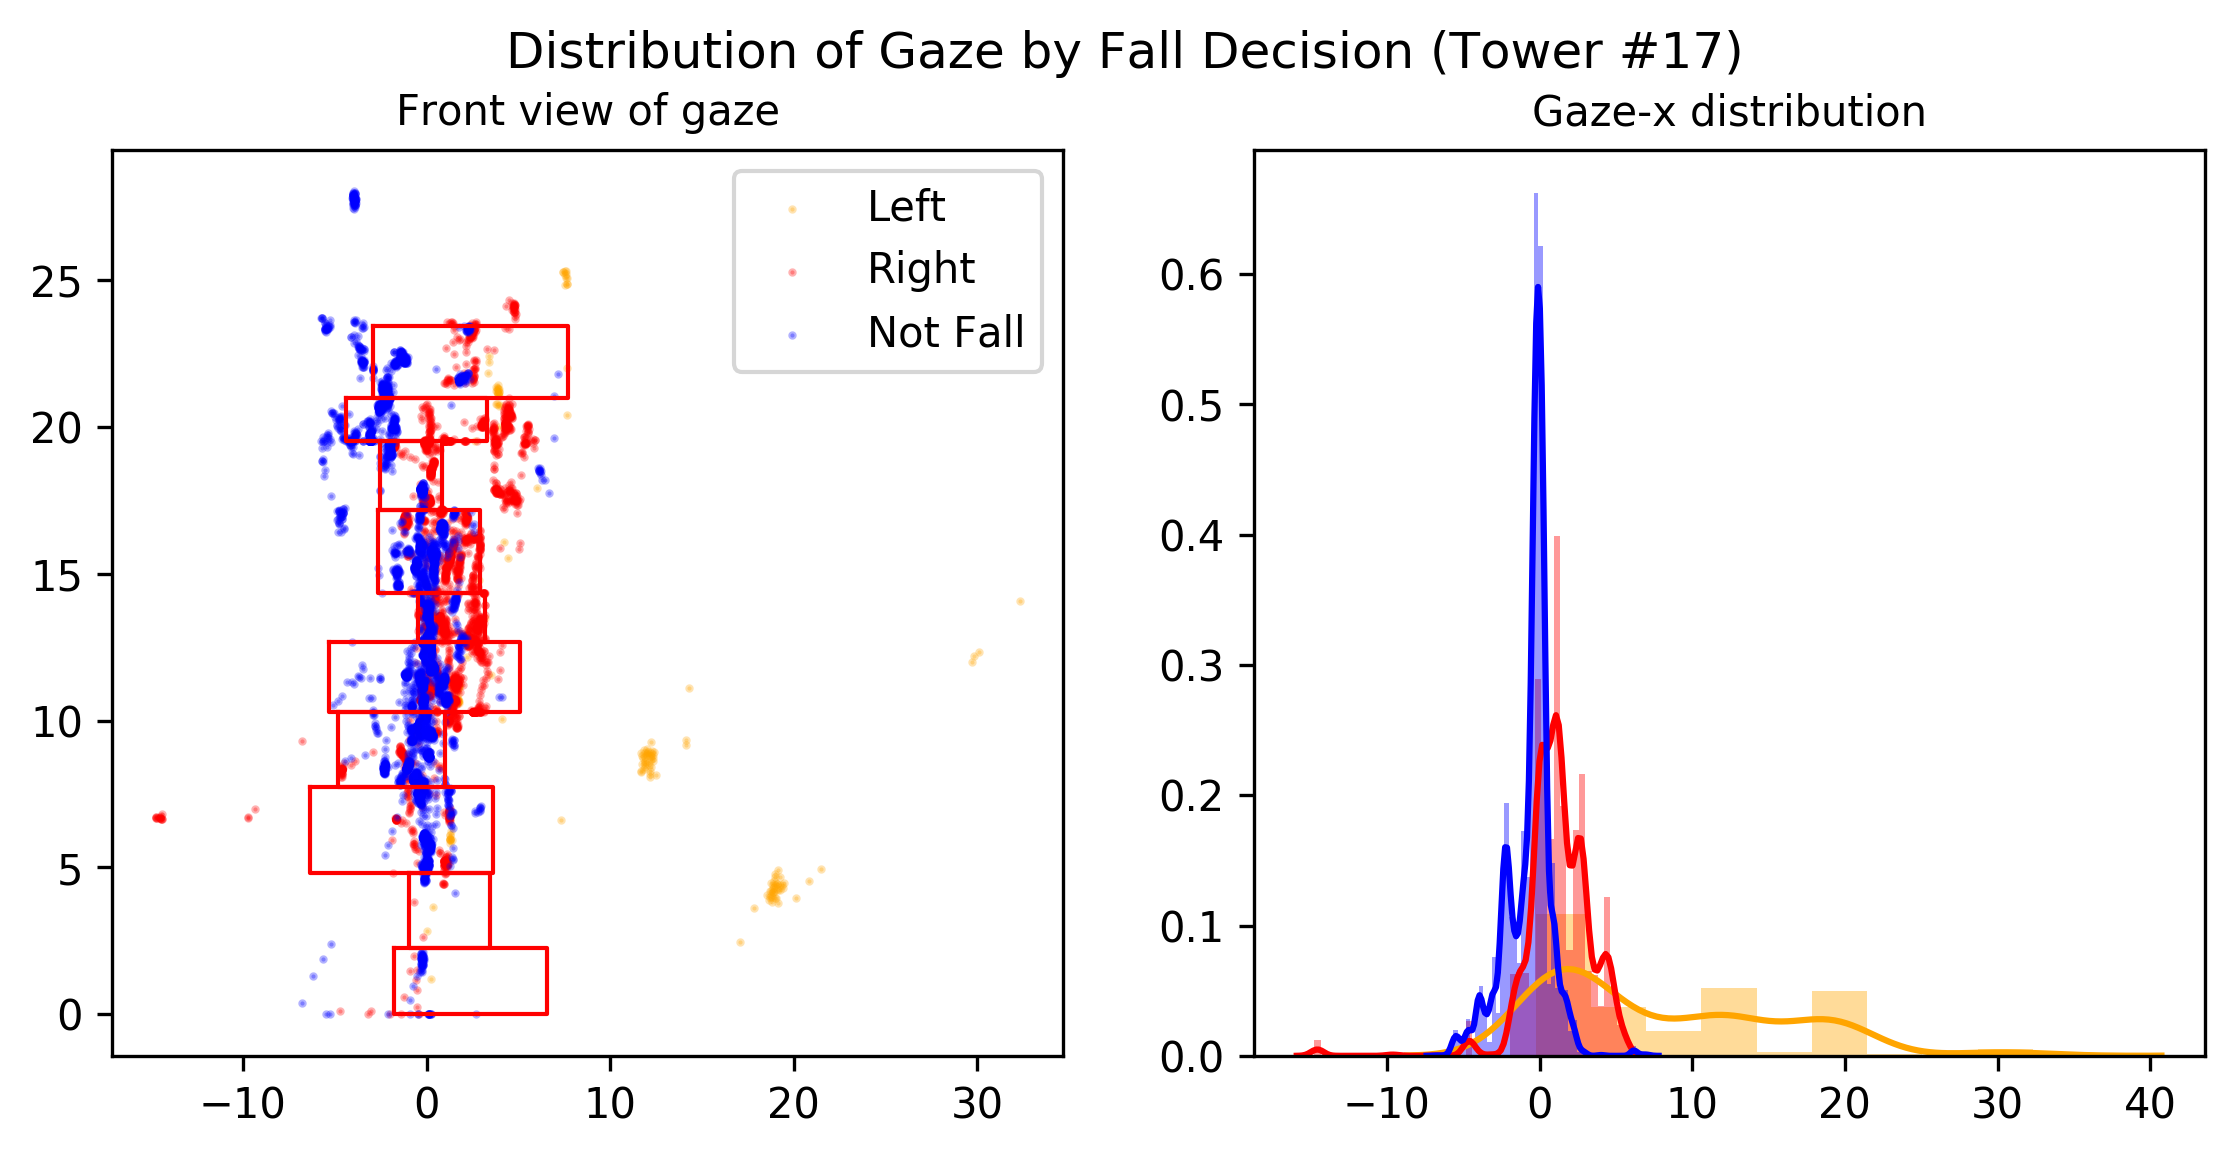

In [281]:
gaze_response_comparison_one_tower(17)

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe'

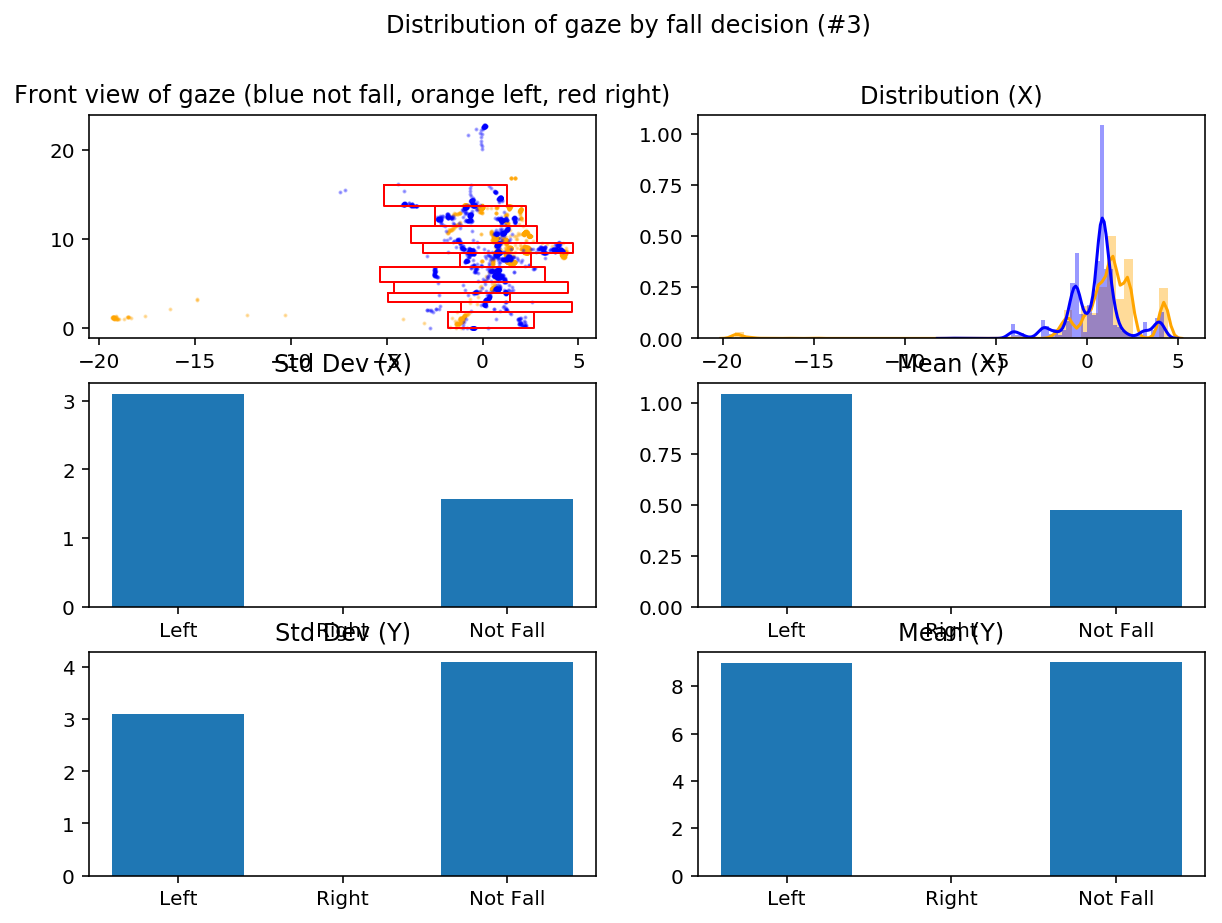

In [55]:
gaze_response_comparison_one_tower(3)

/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/lib/histograms.py:815: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jeremygordon/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe'

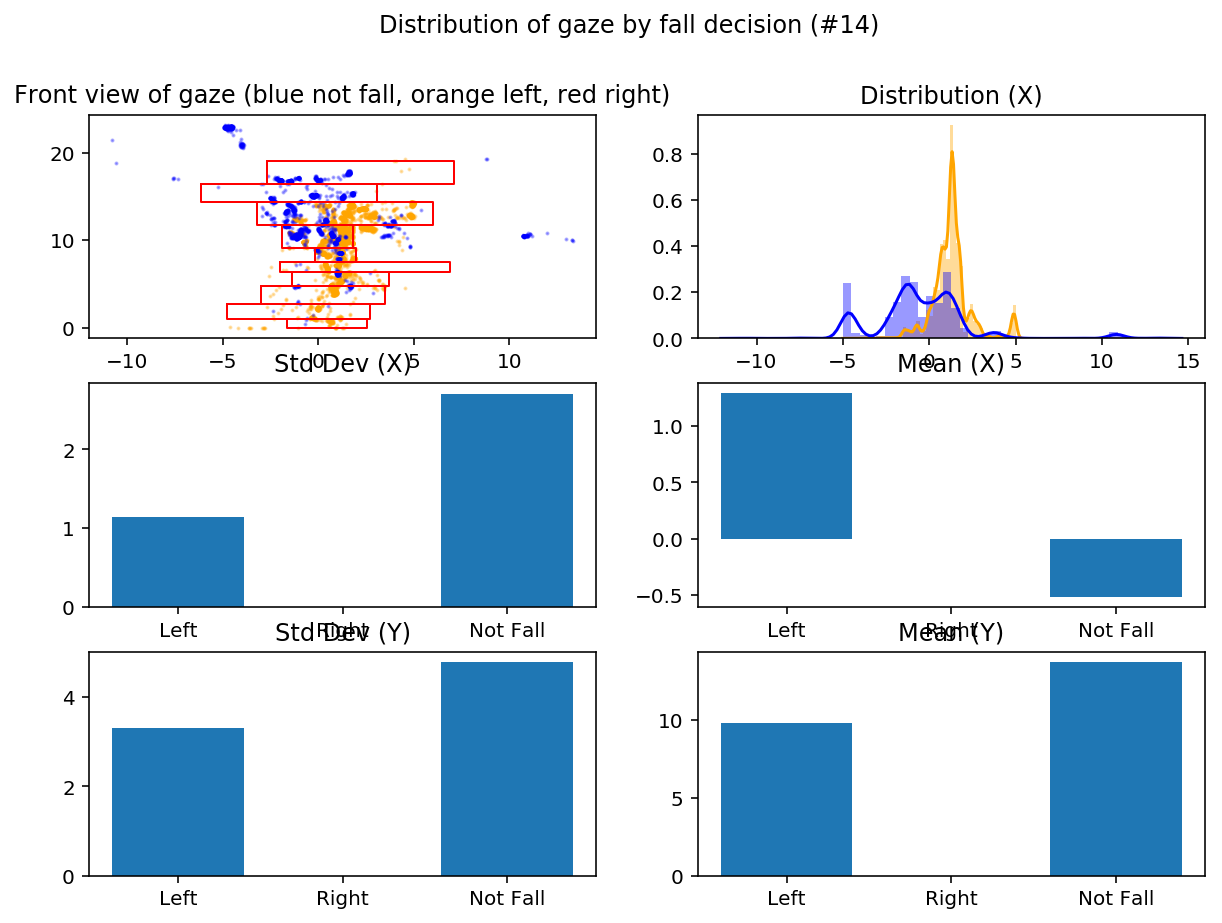

In [56]:
gaze_response_comparison_one_tower(14)

In [142]:
?plt.plot

In [139]:
?np.std